##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 基于 MoveNet 和 TensorFlow Lite 的人体姿势分类

本笔记本将教您如何使用 MoveNet 和 TensorFlow Lite 训练姿势分类模型。结果是一个新的 TensorFlow Lite 模型，该模型接受来自 MoveNet 模型的输出作为其输入，并输出姿势分类，例如瑜伽姿势的名称。

本笔记本中的流程由 3 个部分组成：

- 第 1 部分：将姿势分类训练数据预处理为 CSV 文件，该文件指定 MoveNet 模型检测到的特征点（身体关键点）以及基准真相姿势标签。
- 第 2 部分：构建和训练姿势分类模型，该模型将 CSV 文件中的特征点坐标作为输入，并输出预测的标签。
- 第 3 部分：将姿势分类模型转换为 TFLite。

默认情况下，此笔记本使用一个带有瑜伽姿势标签的图像数据集，但我们在第 1 部分中也包括了一个部分，在那里你可以上传您自己的姿势图像数据集。

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/lite/tutorials/pose_classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/tutorials/pose_classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/tutorials/pose_classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lite/tutorials/pose_classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
  <td>     <a href="https://tfhub.dev/s?q=movenet"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型 </a> </td>
</table>

## 准备

在本部分中，您将导入必要的库并定义几个函数，以将训练图像预处理为包含特征点坐标和基准真相标签的 CSV 文件。

这里没有发生任何可观察到的事情，但是您可以展开隐藏的代码单元，以查看我们稍后将调用的一些函数的实现。

**如果您只想在不了解所有细节的情况下创建 CSV 文件，只需运行本部分并继续第 1 部分。**

In [2]:
!pip install -q opencv-python

In [3]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

2022-08-30 23:59:04.246031: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-08-30 23:59:05.018380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-08-30 23:59:05.018661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-08-30 23:59:05.018675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### 使用 MoveNet 运行姿势预测的代码

In [4]:
#@title Functions to run pose estimation with MoveNet

#@markdown You'll download the MoveNet Thunder model from [TensorFlow Hub](https://www.google.com/url?sa=D&q=https%3A%2F%2Ftfhub.dev%2Fs%3Fq%3Dmovenet), and reuse some inference and visualization logic from the [MoveNet Raspberry Pi (Python)](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app to detect landmarks (ear, nose, wrist etc.) from the input images.

#@markdown *Note: You should use the most accurate pose estimation model (i.e. MoveNet Thunder) to detect the keypoints and use them to train the pose classification model to achieve the best accuracy. When running inference, you can use a pose estimation model of your choice (e.g. either MoveNet Lightning or Thunder).*

# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

Cloning into 'examples'...


remote: Enumerating objects: 22172, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (159/159), done.


remote: Total 22172 (delta 64), reused 156 (delta 38), pack-reused 21938
Receiving objects: 100% (22172/22172), 37.55 MiB | 21.53 MiB/s, done.


Resolving deltas: 100% (12125/12125), done.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
#@title Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [6]:
#@title Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

--2022-08-30 23:59:09--  https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.150.12, 104.18.37.244, 2606:4700:4400::ac40:960c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.150.12|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 17652 (17K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  17.24K  --.-KB/s    in 0s      

2022-08-30 23:59:09 (83.0 MB/s) - ‘/tmp/image.jpeg’ saved [17652/17652]



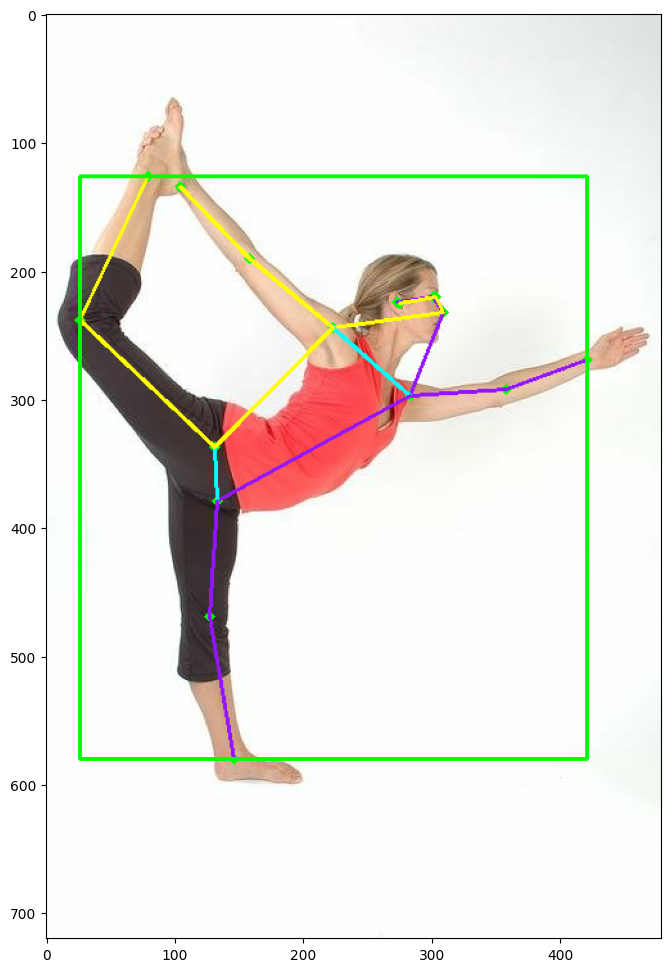

In [7]:
#@title (Optional) Code snippet to try out the Movenet pose estimation logic

#@markdown You can download an image from the internet, run the pose estimation logic on it and plot the detected landmarks on top of the input image. 

#@markdown *Note: This code snippet is also useful for debugging when you encounter an image with bad pose classification accuracy. You can run pose estimation on the image and see if the detected landmarks look correct or not before investigating the pose classification logic.*

test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg" #@param {type:"string"}
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('/tmp/image.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                               close_figure=False, keep_input_size=True)

## 第 1 部分：对输入图像进行预处理

因为我们的姿势分类器的输入是来自 MoveNet 模型的*输出*特征点，所以我们需要通过在 MoveNet 中运行带标签的图像，然后将所有特征点数据和基准真相标签捕获到 CSV 文件中来生成我们的训练数据集。

我们为本教程提供的数据集是由 CG 生成的瑜伽姿势数据集。它包含了多个 CG 生成的模特完成 5 种不同瑜伽姿势的图像。该目录已拆分为 `train` 数据集和 `test` 数据集。

因此，在本部分中，我们将下载瑜伽数据集并通过 MoveNet 运行它，这样我们就可以将所有特征点捕获到 CSV 文件中…**但是，将我们的瑜伽数据集提供给 MoveNet 并生成此 CSV 文件大约需要 15 分钟**。因此，您也可以下载瑜伽数据集的预先存在的 CSV 文件，方法是将下面的 `is_skip_step_1` 参数设置为 **True**。这样，您将跳过此步骤，并改为下载将在此预处理步骤中创建的相同 CSV 文件。

另一方面，如果您希望使用您自己的图像数据集来训练姿势分类器，则需要上传您的图像并运行此预处理步骤（让 `is_skip_step_1` 保持为 **False**），按照下面的说明上传您自己的姿势数据集。

In [8]:
is_skip_step_1 = False #@param ["False", "True"] {type:"raw"}

### （可选）上传您自己的姿势数据集

In [9]:
use_custom_dataset = False #@param ["False", "True"] {type:"raw"}

dataset_is_split = False #@param ["False", "True"] {type:"raw"}

如果您想用自己的带标签姿势训练姿势分类器（它们可以是任何姿势，不仅仅是瑜伽姿势），请按照以下步骤进行操作：

1. 将上面的 `use_custom_dataset` 选项设置为 **True**。

2. 准备一个存档文件（ZIP、TAR 或其他），其中包括内含图像数据集的文件夹。文件夹必须包括您的姿势的排序图像，如下所示。

如果您已将数据集拆分为训练集和测试集，则将 `dataset_is_split` 设置为 **True**。也就是说，您的图像文件夹必须包括如下所示的“训练”和“测试”目录：

```
yoga_poses/ |__ train/ |__ downdog/ |______ 00000128.jpg |______ ... |__ test/ |__ downdog/ |______ 00000181.jpg |______ ...
```

1. 点击左侧的 **Files** 选项卡（文件夹图标），然后点击 **Upload to session storage**（文件图标）。
2. 选择您的存档文件并等待它完成上传，然后再继续。
3. 编辑以下代码块以指定存档文件和图像目录的名称。（默认情况下，我们需要 ZIP 文件，因此如果您的存档是另一种格式，则还需要修改该部分。）
4. 接下来，运行笔记本的剩余内容。

In [10]:
#@markdown Be sure you run this cell. It's hiding the `split_into_train_test()` function that's called in the next code block.

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [11]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  !unzip -q YOUR_DATASET_ARCHIVE_NAME.zip
  dataset_in = 'YOUR_DATASET_DIR_NAME'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

**注**：如果您使用 `split_into_train_test()` 拆分数据集，则它需要所有图像为 PNG、JPEG 或 BMP 格式，并忽略其他文件类型。

### 下载瑜伽数据集

In [12]:
if not is_skip_step_1 and not use_custom_dataset:
  !wget -O yoga_poses.zip http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
  !unzip -q yoga_poses.zip -d yoga_cg
  IMAGES_ROOT = "yoga_cg"

--2022-08-30 23:59:13--  http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.121.128, 2607:f8b0:4001:c19::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.121.128|:80... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 102517581 (98M) [application/zip]
Saving to: ‘yoga_poses.zip’

yoga_poses.zip        0%[                    ]       0  --.-KB/s               

yoga_poses.zip       13%[=>                  ]  13.01M  65.0MB/s               

yoga_poses.zip       49%[========>           ]  48.29M   121MB/s               

yoga_poses.zip       90%[=================>  ]  88.01M   142MB/s               

yoga_poses.zip      100%[===================>]  97.77M   152MB/s    in 0.6s    

2022-08-30 23:59:14 (152 MB/s) - ‘yoga_poses.zip’ saved [102517581/102517581]



### 预处理 `TRAIN` 数据集

In [13]:
if not is_skip_step_1:
  images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing chair


  0%|          | 0/200 [00:00<?, ?it/s]

/tmpfs/tmp/ipykernel_35698/1291585794.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
  1%|          | 2/200 [00:00<00:18, 10.97it/s]

  2%|▏         | 4/200 [00:00<00:17, 11.25it/s]

  3%|▎         | 6/200 [00:00<00:17, 11.37it/s]

  4%|▍         | 8/200 [00:00<00:16, 11.40it/s]

  5%|▌         | 10/200 [00:00<00:16, 11.43it/s]

  6%|▌         | 12/200 [00:01<00:16, 11.36it/s]

  7%|▋         | 14/200 [00:01<00:16, 11.41it/s]

  8%|▊         | 16/200 [00:01<00:21,  8.71it/s]

  9%|▉         | 18/200 [00:01<00:19,  9.50it/s]

 10%|█         | 20/200 [00:01<00:17, 10.06it/s]

 11%|█         | 22/200 [00:02<00:16, 10.51it/s]

 12%|█▏        | 24/200 [00:02<00:16, 10.79it/s]

 13%|█▎        | 26/200 [00:02<00:15, 11.06it/s]

 14%|█▍        | 28/200 [00:02<00:15, 11.26it/s]

 15%|█▌        | 30/200 [00:02<00:15, 11.33it/s]

 16%|█▌        | 32/200 [00:02<00:14, 11.37it/s]

 17%|█▋        | 34/200 [00:03<00:14, 11.50it/s]

 18%|█▊        | 36/200 [00:03<00:14, 11.51it/s]

 19%|█▉        | 38/200 [00:03<00:14, 11.54it/s]

 20%|██        | 40/200 [00:03<00:13, 11.61it/s]

 21%|██        | 42/200 [00:03<00:13, 11.73it/s]

 22%|██▏       | 44/200 [00:03<00:13, 11.74it/s]

 23%|██▎       | 46/200 [00:04<00:13, 11.64it/s]

 24%|██▍       | 48/200 [00:04<00:13, 11.58it/s]

 25%|██▌       | 50/200 [00:04<00:13, 11.53it/s]

 26%|██▌       | 52/200 [00:04<00:12, 11.53it/s]

 27%|██▋       | 54/200 [00:04<00:12, 11.58it/s]

 28%|██▊       | 56/200 [00:05<00:12, 11.62it/s]

 29%|██▉       | 58/200 [00:05<00:12, 11.67it/s]

 30%|███       | 60/200 [00:05<00:12, 11.65it/s]

 31%|███       | 62/200 [00:05<00:15,  8.66it/s]

 32%|███▏      | 64/200 [00:05<00:14,  9.43it/s]

 33%|███▎      | 66/200 [00:06<00:13, 10.01it/s]

 34%|███▍      | 68/200 [00:06<00:12, 10.42it/s]

 35%|███▌      | 70/200 [00:06<00:12, 10.77it/s]

 36%|███▌      | 72/200 [00:06<00:11, 11.03it/s]

 37%|███▋      | 74/200 [00:06<00:11, 11.21it/s]

 38%|███▊      | 76/200 [00:06<00:10, 11.33it/s]

 39%|███▉      | 78/200 [00:07<00:10, 11.45it/s]

 40%|████      | 80/200 [00:07<00:10, 11.46it/s]

 41%|████      | 82/200 [00:07<00:10, 11.60it/s]

 42%|████▏     | 84/200 [00:07<00:09, 11.65it/s]

 43%|████▎     | 86/200 [00:07<00:09, 11.71it/s]

 44%|████▍     | 88/200 [00:07<00:09, 12.40it/s]

 45%|████▌     | 90/200 [00:08<00:08, 12.87it/s]

 46%|████▌     | 92/200 [00:08<00:08, 12.86it/s]

 47%|████▋     | 94/200 [00:08<00:07, 13.31it/s]

 48%|████▊     | 96/200 [00:08<00:07, 13.53it/s]

 49%|████▉     | 98/200 [00:08<00:07, 13.29it/s]

 50%|█████     | 100/200 [00:08<00:07, 13.12it/s]

 51%|█████     | 102/200 [00:08<00:07, 13.45it/s]

 52%|█████▏    | 104/200 [00:09<00:07, 13.68it/s]

 53%|█████▎    | 106/200 [00:09<00:06, 13.76it/s]

 54%|█████▍    | 108/200 [00:09<00:06, 13.82it/s]

 55%|█████▌    | 110/200 [00:09<00:06, 13.90it/s]

 56%|█████▌    | 112/200 [00:09<00:06, 14.00it/s]

 57%|█████▋    | 114/200 [00:09<00:06, 14.00it/s]

 58%|█████▊    | 116/200 [00:09<00:06, 13.13it/s]

 59%|█████▉    | 118/200 [00:10<00:06, 13.03it/s]

 60%|██████    | 120/200 [00:10<00:06, 12.56it/s]

 61%|██████    | 122/200 [00:10<00:06, 12.21it/s]

 62%|██████▏   | 124/200 [00:10<00:06, 12.07it/s]

 63%|██████▎   | 126/200 [00:10<00:06, 11.97it/s]

 64%|██████▍   | 128/200 [00:10<00:06, 11.85it/s]

 65%|██████▌   | 130/200 [00:11<00:05, 11.72it/s]

 66%|██████▌   | 132/200 [00:11<00:05, 12.06it/s]

 67%|██████▋   | 134/200 [00:11<00:05, 11.94it/s]

 68%|██████▊   | 136/200 [00:11<00:05, 11.89it/s]

 69%|██████▉   | 138/200 [00:11<00:05, 11.81it/s]

 70%|███████   | 140/200 [00:12<00:05, 11.75it/s]

 71%|███████   | 142/200 [00:12<00:04, 11.75it/s]

 72%|███████▏  | 144/200 [00:12<00:04, 11.72it/s]

 73%|███████▎  | 146/200 [00:12<00:06,  8.12it/s]

 74%|███████▍  | 148/200 [00:12<00:05,  8.92it/s]

 75%|███████▌  | 150/200 [00:13<00:05,  9.60it/s]

 76%|███████▌  | 152/200 [00:13<00:04, 10.11it/s]

 77%|███████▋  | 154/200 [00:13<00:04, 10.76it/s]

 78%|███████▊  | 156/200 [00:13<00:03, 11.28it/s]

 79%|███████▉  | 158/200 [00:13<00:03, 12.00it/s]

 80%|████████  | 160/200 [00:13<00:03, 12.58it/s]

 81%|████████  | 162/200 [00:14<00:03, 12.23it/s]

 82%|████████▏ | 164/200 [00:14<00:02, 12.05it/s]

 83%|████████▎ | 166/200 [00:14<00:02, 11.88it/s]

 84%|████████▍ | 168/200 [00:14<00:02, 11.74it/s]

 85%|████████▌ | 170/200 [00:14<00:02, 11.79it/s]

 86%|████████▌ | 172/200 [00:14<00:02, 11.79it/s]

 87%|████████▋ | 174/200 [00:15<00:02, 11.76it/s]

 88%|████████▊ | 176/200 [00:15<00:02, 11.66it/s]

 89%|████████▉ | 178/200 [00:15<00:01, 11.61it/s]

 90%|█████████ | 180/200 [00:15<00:01, 11.59it/s]

 91%|█████████ | 182/200 [00:15<00:01, 11.57it/s]

 92%|█████████▏| 184/200 [00:15<00:01, 11.56it/s]

 93%|█████████▎| 186/200 [00:16<00:01, 11.51it/s]

 94%|█████████▍| 188/200 [00:16<00:01, 11.48it/s]

 95%|█████████▌| 190/200 [00:16<00:00, 11.48it/s]

 96%|█████████▌| 192/200 [00:16<00:00, 11.50it/s]

 97%|█████████▋| 194/200 [00:16<00:00, 11.55it/s]

 98%|█████████▊| 196/200 [00:17<00:00, 11.54it/s]

 99%|█████████▉| 198/200 [00:17<00:00, 11.57it/s]

100%|██████████| 200/200 [00:17<00:00, 11.55it/s]

100%|██████████| 200/200 [00:17<00:00, 11.53it/s]


Preprocessing cobra


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:14, 13.76it/s]

  2%|▏         | 4/200 [00:00<00:14, 13.82it/s]

  3%|▎         | 6/200 [00:00<00:13, 13.89it/s]

  4%|▍         | 8/200 [00:00<00:13, 13.89it/s]

  5%|▌         | 10/200 [00:00<00:13, 13.89it/s]

  6%|▌         | 12/200 [00:00<00:13, 13.83it/s]

  7%|▋         | 14/200 [00:01<00:13, 13.87it/s]

  8%|▊         | 16/200 [00:01<00:14, 13.04it/s]

  9%|▉         | 18/200 [00:01<00:13, 13.41it/s]

 10%|█         | 20/200 [00:01<00:13, 13.61it/s]

 11%|█         | 22/200 [00:01<00:12, 13.73it/s]

 12%|█▏        | 24/200 [00:01<00:12, 13.84it/s]

 13%|█▎        | 26/200 [00:01<00:12, 13.93it/s]

 14%|█▍        | 28/200 [00:02<00:12, 13.95it/s]

 15%|█▌        | 30/200 [00:02<00:12, 13.90it/s]

 16%|█▌        | 32/200 [00:02<00:12, 13.95it/s]

 17%|█▋        | 34/200 [00:02<00:11, 14.07it/s]

 18%|█▊        | 36/200 [00:02<00:11, 14.04it/s]

 19%|█▉        | 38/200 [00:02<00:11, 13.59it/s]

 20%|██        | 40/200 [00:02<00:12, 13.28it/s]

 21%|██        | 42/200 [00:03<00:12, 12.65it/s]

 22%|██▏       | 44/200 [00:03<00:12, 12.32it/s]

 23%|██▎       | 46/200 [00:03<00:12, 12.13it/s]

 24%|██▍       | 48/200 [00:03<00:12, 12.33it/s]

 25%|██▌       | 50/200 [00:03<00:12, 12.41it/s]

 26%|██▌       | 52/200 [00:03<00:11, 12.49it/s]

 27%|██▋       | 54/200 [00:04<00:11, 12.19it/s]

 28%|██▊       | 56/200 [00:04<00:12, 11.99it/s]

 29%|██▉       | 58/200 [00:04<00:11, 11.86it/s]

 30%|███       | 60/200 [00:04<00:11, 11.77it/s]

 31%|███       | 62/200 [00:05<00:18,  7.47it/s]

 32%|███▏      | 64/200 [00:05<00:16,  8.41it/s]

 33%|███▎      | 66/200 [00:05<00:14,  9.18it/s]

 34%|███▍      | 68/200 [00:05<00:13,  9.81it/s]

 35%|███▌      | 70/200 [00:05<00:12, 10.57it/s]

 36%|███▌      | 72/200 [00:05<00:11, 11.16it/s]

 37%|███▋      | 74/200 [00:06<00:11, 11.29it/s]

 38%|███▊      | 76/200 [00:06<00:10, 11.71it/s]

 39%|███▉      | 78/200 [00:06<00:10, 12.01it/s]

 40%|████      | 80/200 [00:06<00:09, 12.60it/s]

 41%|████      | 82/200 [00:06<00:09, 13.02it/s]

 42%|████▏     | 84/200 [00:06<00:08, 13.37it/s]

 43%|████▎     | 86/200 [00:06<00:08, 13.61it/s]

 44%|████▍     | 88/200 [00:07<00:08, 13.70it/s]

 45%|████▌     | 90/200 [00:07<00:08, 13.33it/s]

 46%|████▌     | 92/200 [00:07<00:08, 13.15it/s]

 47%|████▋     | 94/200 [00:07<00:07, 13.45it/s]

 48%|████▊     | 96/200 [00:07<00:07, 13.68it/s]

 49%|████▉     | 98/200 [00:07<00:07, 13.84it/s]

 50%|█████     | 100/200 [00:08<00:07, 13.46it/s]

 51%|█████     | 102/200 [00:08<00:07, 13.23it/s]

 52%|█████▏    | 104/200 [00:08<00:07, 13.08it/s]

 53%|█████▎    | 106/200 [00:08<00:07, 12.97it/s]

 54%|█████▍    | 108/200 [00:08<00:07, 12.54it/s]

 55%|█████▌    | 110/200 [00:08<00:07, 12.22it/s]

 56%|█████▌    | 112/200 [00:08<00:07, 11.97it/s]

 57%|█████▋    | 114/200 [00:09<00:07, 12.15it/s]

 58%|█████▊    | 116/200 [00:09<00:06, 12.69it/s]

 59%|█████▉    | 118/200 [00:09<00:06, 13.04it/s]

 60%|██████    | 120/200 [00:09<00:06, 12.51it/s]

 61%|██████    | 122/200 [00:09<00:06, 12.15it/s]

 62%|██████▏   | 124/200 [00:09<00:06, 11.98it/s]

 63%|██████▎   | 126/200 [00:10<00:06, 11.80it/s]

 64%|██████▍   | 128/200 [00:10<00:06, 11.73it/s]

 65%|██████▌   | 130/200 [00:10<00:05, 11.72it/s]

 66%|██████▌   | 132/200 [00:10<00:05, 11.71it/s]

 67%|██████▋   | 134/200 [00:10<00:05, 11.66it/s]

 68%|██████▊   | 136/200 [00:11<00:05, 11.63it/s]

 69%|██████▉   | 138/200 [00:11<00:05, 11.56it/s]

 70%|███████   | 140/200 [00:11<00:05, 11.59it/s]

 71%|███████   | 142/200 [00:11<00:04, 11.60it/s]

 72%|███████▏  | 144/200 [00:11<00:04, 11.65it/s]

 73%|███████▎  | 146/200 [00:11<00:04, 11.66it/s]

 74%|███████▍  | 148/200 [00:12<00:04, 11.65it/s]

 75%|███████▌  | 150/200 [00:12<00:04, 11.64it/s]

 76%|███████▌  | 152/200 [00:12<00:04, 11.64it/s]

 77%|███████▋  | 154/200 [00:12<00:03, 11.68it/s]

 78%|███████▊  | 156/200 [00:12<00:03, 11.63it/s]

 79%|███████▉  | 158/200 [00:12<00:03, 11.60it/s]

 80%|████████  | 160/200 [00:13<00:03, 12.01it/s]

 81%|████████  | 162/200 [00:13<00:03, 11.96it/s]

 82%|████████▏ | 164/200 [00:13<00:02, 12.22it/s]

 83%|████████▎ | 166/200 [00:13<00:02, 12.73it/s]

 84%|████████▍ | 168/200 [00:13<00:02, 12.45it/s]

 85%|████████▌ | 170/200 [00:13<00:02, 12.46it/s]

 86%|████████▌ | 172/200 [00:14<00:02, 12.53it/s]

 87%|████████▋ | 174/200 [00:14<00:02, 13.00it/s]

 88%|████████▊ | 176/200 [00:14<00:01, 13.35it/s]

 89%|████████▉ | 178/200 [00:14<00:01, 13.65it/s]

 90%|█████████ | 180/200 [00:14<00:01, 13.45it/s]

 91%|█████████ | 182/200 [00:14<00:01, 12.88it/s]

 92%|█████████▏| 184/200 [00:14<00:01, 12.38it/s]

 93%|█████████▎| 186/200 [00:15<00:01, 12.44it/s]

 94%|█████████▍| 188/200 [00:15<00:00, 12.87it/s]

 95%|█████████▌| 190/200 [00:15<00:00, 12.46it/s]

 96%|█████████▌| 192/200 [00:15<00:00, 12.13it/s]

 97%|█████████▋| 194/200 [00:15<00:00, 11.95it/s]

 98%|█████████▊| 196/200 [00:15<00:00, 11.80it/s]

 99%|█████████▉| 198/200 [00:16<00:00,  6.85it/s]

100%|██████████| 200/200 [00:16<00:00,  7.98it/s]

100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


Preprocessing dog


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:13, 14.35it/s]

  2%|▏         | 4/200 [00:00<00:14, 13.10it/s]

  3%|▎         | 6/200 [00:00<00:15, 12.89it/s]

  4%|▍         | 8/200 [00:00<00:15, 12.41it/s]

  5%|▌         | 10/200 [00:00<00:15, 12.12it/s]

  6%|▌         | 12/200 [00:00<00:15, 11.93it/s]

  7%|▋         | 14/200 [00:01<00:15, 11.81it/s]

  8%|▊         | 16/200 [00:01<00:15, 11.73it/s]

  9%|▉         | 18/200 [00:01<00:15, 11.65it/s]

 10%|█         | 20/200 [00:01<00:15, 11.65it/s]

 11%|█         | 22/200 [00:01<00:15, 11.56it/s]

 12%|█▏        | 24/200 [00:02<00:15, 11.55it/s]

 13%|█▎        | 26/200 [00:02<00:14, 11.60it/s]

 14%|█▍        | 28/200 [00:02<00:14, 11.56it/s]

 15%|█▌        | 30/200 [00:02<00:14, 11.54it/s]

 16%|█▌        | 32/200 [00:02<00:14, 11.59it/s]

 17%|█▋        | 34/200 [00:02<00:14, 11.58it/s]

 18%|█▊        | 36/200 [00:03<00:14, 11.62it/s]

 19%|█▉        | 38/200 [00:03<00:13, 11.59it/s]

 20%|██        | 40/200 [00:03<00:13, 11.64it/s]

 21%|██        | 42/200 [00:03<00:13, 11.66it/s]

 22%|██▏       | 44/200 [00:03<00:13, 11.66it/s]

 23%|██▎       | 46/200 [00:03<00:13, 11.70it/s]

 24%|██▍       | 48/200 [00:04<00:12, 11.84it/s]

 25%|██▌       | 50/200 [00:04<00:12, 11.86it/s]

 26%|██▌       | 52/200 [00:04<00:12, 11.89it/s]

 27%|██▋       | 54/200 [00:04<00:12, 11.92it/s]

 28%|██▊       | 56/200 [00:04<00:12, 11.96it/s]

 29%|██▉       | 58/200 [00:04<00:11, 11.88it/s]

 30%|███       | 60/200 [00:05<00:11, 11.85it/s]

 31%|███       | 62/200 [00:05<00:11, 11.82it/s]

 32%|███▏      | 64/200 [00:05<00:11, 11.80it/s]

 33%|███▎      | 66/200 [00:05<00:11, 11.80it/s]

 34%|███▍      | 68/200 [00:05<00:11, 11.77it/s]

 35%|███▌      | 70/200 [00:05<00:11, 11.78it/s]

 36%|███▌      | 72/200 [00:06<00:10, 12.14it/s]

 37%|███▋      | 74/200 [00:06<00:09, 12.71it/s]

 38%|███▊      | 76/200 [00:06<00:09, 13.14it/s]

 39%|███▉      | 78/200 [00:06<00:09, 13.46it/s]

 40%|████      | 80/200 [00:06<00:08, 13.73it/s]

 41%|████      | 82/200 [00:06<00:08, 13.91it/s]

 42%|████▏     | 84/200 [00:06<00:08, 14.04it/s]

 43%|████▎     | 86/200 [00:07<00:08, 14.15it/s]

 44%|████▍     | 88/200 [00:07<00:07, 14.26it/s]

 45%|████▌     | 90/200 [00:07<00:07, 14.26it/s]

 46%|████▌     | 92/200 [00:07<00:07, 14.14it/s]

 47%|████▋     | 94/200 [00:07<00:07, 14.15it/s]

 48%|████▊     | 96/200 [00:07<00:07, 14.18it/s]

 49%|████▉     | 98/200 [00:07<00:07, 14.23it/s]

 50%|█████     | 100/200 [00:08<00:07, 14.24it/s]

 51%|█████     | 102/200 [00:08<00:07, 13.34it/s]

 52%|█████▏    | 104/200 [00:08<00:07, 13.58it/s]

 53%|█████▎    | 106/200 [00:08<00:07, 13.30it/s]

 54%|█████▍    | 108/200 [00:08<00:06, 13.52it/s]

 55%|█████▌    | 110/200 [00:08<00:06, 13.68it/s]

 56%|█████▌    | 112/200 [00:08<00:06, 13.80it/s]

 57%|█████▋    | 114/200 [00:09<00:06, 13.91it/s]

 58%|█████▊    | 116/200 [00:09<00:06, 13.98it/s]

 59%|█████▉    | 118/200 [00:09<00:05, 13.98it/s]

 60%|██████    | 120/200 [00:09<00:05, 13.99it/s]

 61%|██████    | 122/200 [00:09<00:05, 14.11it/s]

 62%|██████▏   | 124/200 [00:09<00:05, 14.07it/s]

 63%|██████▎   | 126/200 [00:09<00:05, 14.10it/s]

 64%|██████▍   | 128/200 [00:10<00:05, 13.17it/s]

 65%|██████▌   | 130/200 [00:10<00:05, 12.67it/s]

 66%|██████▌   | 132/200 [00:10<00:05, 12.35it/s]

 67%|██████▋   | 134/200 [00:10<00:05, 12.05it/s]

 68%|██████▊   | 136/200 [00:10<00:05, 11.85it/s]

 69%|██████▉   | 138/200 [00:10<00:05, 11.75it/s]

 70%|███████   | 140/200 [00:11<00:05, 11.64it/s]

 71%|███████   | 142/200 [00:11<00:04, 11.87it/s]

 72%|███████▏  | 144/200 [00:11<00:04, 12.13it/s]

 73%|███████▎  | 146/200 [00:11<00:04, 11.96it/s]

 74%|███████▍  | 148/200 [00:11<00:04, 11.82it/s]

 75%|███████▌  | 150/200 [00:11<00:04, 11.71it/s]

 76%|███████▌  | 152/200 [00:12<00:04, 11.66it/s]

 77%|███████▋  | 154/200 [00:12<00:03, 11.64it/s]

 78%|███████▊  | 156/200 [00:12<00:03, 11.63it/s]

 79%|███████▉  | 158/200 [00:12<00:03, 11.60it/s]

 80%|████████  | 160/200 [00:12<00:03, 11.58it/s]

 81%|████████  | 162/200 [00:13<00:03, 11.58it/s]

 82%|████████▏ | 164/200 [00:13<00:03, 11.58it/s]

 83%|████████▎ | 166/200 [00:13<00:05,  6.13it/s]

 84%|████████▍ | 168/200 [00:14<00:04,  7.13it/s]

 85%|████████▌ | 170/200 [00:14<00:03,  7.99it/s]

 86%|████████▌ | 172/200 [00:14<00:03,  8.79it/s]

 87%|████████▋ | 174/200 [00:14<00:02,  9.42it/s]

 88%|████████▊ | 176/200 [00:14<00:02,  9.94it/s]

 89%|████████▉ | 178/200 [00:14<00:02, 10.38it/s]

 90%|█████████ | 180/200 [00:15<00:01, 10.71it/s]

 91%|█████████ | 182/200 [00:15<00:01, 10.97it/s]

 92%|█████████▏| 184/200 [00:15<00:01, 11.47it/s]

 93%|█████████▎| 186/200 [00:15<00:01, 11.78it/s]

 94%|█████████▍| 188/200 [00:15<00:01, 11.73it/s]

 95%|█████████▌| 190/200 [00:15<00:00, 12.01it/s]

 96%|█████████▌| 192/200 [00:16<00:00, 11.88it/s]

 97%|█████████▋| 194/200 [00:16<00:00, 11.81it/s]

 98%|█████████▊| 196/200 [00:16<00:00, 11.71it/s]

 99%|█████████▉| 198/200 [00:16<00:00, 11.64it/s]

100%|██████████| 200/200 [00:16<00:00, 11.56it/s]

100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


Preprocessing tree


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:17, 11.62it/s]

  2%|▏         | 4/200 [00:00<00:16, 11.71it/s]

  3%|▎         | 6/200 [00:00<00:16, 11.61it/s]

  4%|▍         | 8/200 [00:00<00:16, 11.57it/s]

  5%|▌         | 10/200 [00:00<00:16, 11.60it/s]

  6%|▌         | 12/200 [00:01<00:16, 11.62it/s]

  7%|▋         | 14/200 [00:01<00:15, 11.66it/s]

  8%|▊         | 16/200 [00:01<00:15, 11.61it/s]

  9%|▉         | 18/200 [00:01<00:15, 11.61it/s]

 10%|█         | 20/200 [00:01<00:15, 11.60it/s]

 11%|█         | 22/200 [00:01<00:15, 11.59it/s]

 12%|█▏        | 24/200 [00:02<00:15, 11.57it/s]

 13%|█▎        | 26/200 [00:02<00:15, 11.55it/s]

 14%|█▍        | 28/200 [00:02<00:14, 11.51it/s]

 15%|█▌        | 30/200 [00:02<00:14, 11.51it/s]

 16%|█▌        | 32/200 [00:02<00:14, 11.56it/s]

 17%|█▋        | 34/200 [00:02<00:14, 11.61it/s]

 18%|█▊        | 36/200 [00:03<00:14, 11.55it/s]

 19%|█▉        | 38/200 [00:03<00:14, 11.52it/s]

 20%|██        | 40/200 [00:03<00:13, 11.52it/s]

 21%|██        | 42/200 [00:03<00:13, 11.53it/s]

 22%|██▏       | 44/200 [00:03<00:13, 11.51it/s]

 23%|██▎       | 46/200 [00:03<00:13, 11.53it/s]

 24%|██▍       | 48/200 [00:04<00:13, 11.58it/s]

 25%|██▌       | 50/200 [00:04<00:12, 11.62it/s]

 26%|██▌       | 52/200 [00:04<00:12, 11.57it/s]

 27%|██▋       | 54/200 [00:04<00:12, 11.59it/s]

 28%|██▊       | 56/200 [00:04<00:12, 11.91it/s]

 29%|██▉       | 58/200 [00:04<00:11, 12.14it/s]

 30%|███       | 60/200 [00:05<00:11, 11.91it/s]

 31%|███       | 62/200 [00:05<00:11, 11.79it/s]

 32%|███▏      | 64/200 [00:05<00:11, 11.73it/s]

 33%|███▎      | 66/200 [00:05<00:11, 11.69it/s]

 34%|███▍      | 68/200 [00:05<00:11, 11.71it/s]

 35%|███▌      | 70/200 [00:06<00:11, 11.69it/s]

 36%|███▌      | 72/200 [00:06<00:10, 11.67it/s]

 37%|███▋      | 74/200 [00:06<00:10, 11.72it/s]

 38%|███▊      | 76/200 [00:06<00:10, 11.70it/s]

 39%|███▉      | 78/200 [00:06<00:10, 11.75it/s]

 40%|████      | 80/200 [00:06<00:10, 11.76it/s]

 41%|████      | 82/200 [00:07<00:09, 12.12it/s]

 42%|████▏     | 84/200 [00:07<00:09, 12.32it/s]

 43%|████▎     | 86/200 [00:07<00:09, 12.13it/s]

 44%|████▍     | 88/200 [00:07<00:09, 12.05it/s]

 45%|████▌     | 90/200 [00:07<00:09, 11.99it/s]

 46%|████▌     | 92/200 [00:07<00:09, 11.90it/s]

 47%|████▋     | 94/200 [00:08<00:08, 11.80it/s]

 48%|████▊     | 96/200 [00:08<00:08, 11.77it/s]

 49%|████▉     | 98/200 [00:08<00:08, 11.67it/s]

 50%|█████     | 100/200 [00:08<00:08, 11.63it/s]

 51%|█████     | 102/200 [00:08<00:08, 11.64it/s]

 52%|█████▏    | 104/200 [00:08<00:08, 11.61it/s]

 53%|█████▎    | 106/200 [00:09<00:08, 11.56it/s]

 54%|█████▍    | 108/200 [00:09<00:07, 11.57it/s]

 55%|█████▌    | 110/200 [00:10<00:16,  5.50it/s]

 56%|█████▌    | 112/200 [00:10<00:13,  6.53it/s]

 57%|█████▋    | 114/200 [00:10<00:11,  7.50it/s]

 58%|█████▊    | 116/200 [00:10<00:10,  8.37it/s]

 59%|█████▉    | 118/200 [00:10<00:08,  9.13it/s]

 60%|██████    | 120/200 [00:10<00:08,  9.75it/s]

 61%|██████    | 122/200 [00:11<00:07, 10.21it/s]

 62%|██████▏   | 124/200 [00:11<00:07, 10.55it/s]

 63%|██████▎   | 126/200 [00:11<00:06, 10.80it/s]

 64%|██████▍   | 128/200 [00:11<00:06, 11.06it/s]

 65%|██████▌   | 130/200 [00:11<00:06, 11.20it/s]

 66%|██████▌   | 132/200 [00:11<00:06, 11.24it/s]

 67%|██████▋   | 134/200 [00:12<00:05, 11.27it/s]

 68%|██████▊   | 136/200 [00:12<00:05, 11.38it/s]

 69%|██████▉   | 138/200 [00:12<00:05, 11.44it/s]

 70%|███████   | 140/200 [00:12<00:05, 11.45it/s]

 71%|███████   | 142/200 [00:12<00:05, 11.56it/s]

 72%|███████▏  | 144/200 [00:12<00:04, 11.61it/s]

 73%|███████▎  | 146/200 [00:13<00:04, 11.57it/s]

 74%|███████▍  | 148/200 [00:13<00:04, 11.61it/s]

 75%|███████▌  | 150/200 [00:13<00:04, 11.53it/s]

 76%|███████▌  | 152/200 [00:13<00:04, 11.56it/s]

 77%|███████▋  | 154/200 [00:13<00:03, 11.59it/s]

 78%|███████▊  | 156/200 [00:13<00:03, 12.27it/s]

 79%|███████▉  | 158/200 [00:14<00:03, 12.80it/s]

 80%|████████  | 160/200 [00:14<00:03, 12.42it/s]

 81%|████████  | 162/200 [00:14<00:02, 12.86it/s]

 82%|████████▏ | 164/200 [00:14<00:02, 13.25it/s]

 83%|████████▎ | 166/200 [00:14<00:02, 13.17it/s]

 84%|████████▍ | 168/200 [00:14<00:02, 13.13it/s]

 85%|████████▌ | 170/200 [00:15<00:02, 12.71it/s]

 86%|████████▌ | 172/200 [00:15<00:02, 12.41it/s]

 87%|████████▋ | 174/200 [00:15<00:02, 12.22it/s]

 88%|████████▊ | 176/200 [00:15<00:01, 12.06it/s]

 89%|████████▉ | 178/200 [00:15<00:01, 11.94it/s]

 90%|█████████ | 180/200 [00:15<00:01, 11.81it/s]

 91%|█████████ | 182/200 [00:16<00:01, 11.76it/s]

 92%|█████████▏| 184/200 [00:16<00:01, 11.73it/s]

 93%|█████████▎| 186/200 [00:16<00:01, 11.66it/s]

 94%|█████████▍| 188/200 [00:16<00:01, 11.67it/s]

 95%|█████████▌| 190/200 [00:16<00:00, 11.67it/s]

 96%|█████████▌| 192/200 [00:16<00:00, 11.69it/s]

 97%|█████████▋| 194/200 [00:17<00:00, 11.69it/s]

 98%|█████████▊| 196/200 [00:17<00:00, 11.68it/s]

 99%|█████████▉| 198/200 [00:17<00:00, 11.60it/s]

100%|██████████| 200/200 [00:17<00:00, 12.21it/s]

100%|██████████| 200/200 [00:17<00:00, 11.35it/s]


Preprocessing warrior


  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:00<00:16, 11.66it/s]

  2%|▏         | 4/200 [00:00<00:15, 12.97it/s]

  3%|▎         | 6/200 [00:00<00:14, 13.57it/s]

  4%|▍         | 8/200 [00:00<00:13, 13.89it/s]

  5%|▌         | 10/200 [00:00<00:13, 13.92it/s]

  6%|▌         | 12/200 [00:00<00:13, 13.96it/s]

  7%|▋         | 14/200 [00:01<00:13, 14.12it/s]

  8%|▊         | 16/200 [00:01<00:12, 14.24it/s]

  9%|▉         | 18/200 [00:01<00:12, 14.29it/s]

 10%|█         | 20/200 [00:01<00:12, 14.30it/s]

 11%|█         | 22/200 [00:01<00:12, 14.36it/s]

 12%|█▏        | 24/200 [00:01<00:12, 14.30it/s]

 13%|█▎        | 26/200 [00:01<00:12, 14.20it/s]

 14%|█▍        | 28/200 [00:01<00:12, 14.20it/s]

 15%|█▌        | 30/200 [00:02<00:11, 14.21it/s]

 16%|█▌        | 32/200 [00:02<00:12, 13.35it/s]

 17%|█▋        | 34/200 [00:02<00:12, 12.81it/s]

 18%|█▊        | 36/200 [00:02<00:13, 12.49it/s]

 19%|█▉        | 38/200 [00:02<00:13, 12.12it/s]

 20%|██        | 40/200 [00:02<00:13, 11.91it/s]

 21%|██        | 42/200 [00:03<00:12, 12.45it/s]

 22%|██▏       | 44/200 [00:03<00:12, 12.92it/s]

 23%|██▎       | 46/200 [00:03<00:11, 13.34it/s]

 24%|██▍       | 48/200 [00:03<00:11, 13.68it/s]

 25%|██▌       | 50/200 [00:03<00:11, 13.36it/s]

 26%|██▌       | 52/200 [00:03<00:10, 13.58it/s]

 27%|██▋       | 54/200 [00:03<00:10, 13.79it/s]

 28%|██▊       | 56/200 [00:04<00:10, 13.47it/s]

 29%|██▉       | 58/200 [00:04<00:10, 13.24it/s]

 30%|███       | 60/200 [00:04<00:10, 13.49it/s]

 31%|███       | 62/200 [00:04<00:10, 13.28it/s]

 32%|███▏      | 64/200 [00:04<00:10, 12.72it/s]

 33%|███▎      | 66/200 [00:04<00:10, 12.34it/s]

 34%|███▍      | 68/200 [00:05<00:10, 12.05it/s]

 35%|███▌      | 70/200 [00:05<00:10, 11.91it/s]

 36%|███▌      | 72/200 [00:05<00:10, 11.83it/s]

 37%|███▋      | 74/200 [00:05<00:10, 11.79it/s]

 38%|███▊      | 76/200 [00:05<00:10, 11.76it/s]

 39%|███▉      | 78/200 [00:05<00:09, 12.41it/s]

 40%|████      | 80/200 [00:06<00:09, 12.95it/s]

 41%|████      | 82/200 [00:06<00:09, 12.92it/s]

 42%|████▏     | 84/200 [00:06<00:08, 13.24it/s]

 43%|████▎     | 86/200 [00:06<00:08, 13.44it/s]

 44%|████▍     | 88/200 [00:06<00:08, 13.66it/s]

 45%|████▌     | 90/200 [00:06<00:08, 13.72it/s]

 46%|████▌     | 92/200 [00:06<00:07, 13.74it/s]

 47%|████▋     | 94/200 [00:07<00:07, 13.39it/s]

 48%|████▊     | 96/200 [00:07<00:07, 13.51it/s]

 49%|████▉     | 98/200 [00:07<00:07, 13.64it/s]

 50%|█████     | 100/200 [00:07<00:07, 13.75it/s]

 51%|█████     | 102/200 [00:07<00:07, 13.93it/s]

 52%|█████▏    | 104/200 [00:07<00:06, 13.89it/s]

 53%|█████▎    | 106/200 [00:07<00:06, 13.92it/s]

 54%|█████▍    | 108/200 [00:08<00:07, 13.07it/s]

 55%|█████▌    | 110/200 [00:08<00:07, 12.51it/s]

 56%|█████▌    | 112/200 [00:08<00:07, 12.51it/s]

 57%|█████▋    | 114/200 [00:08<00:06, 12.49it/s]

 58%|█████▊    | 116/200 [00:08<00:06, 12.53it/s]

 59%|█████▉    | 118/200 [00:08<00:06, 12.18it/s]

 60%|██████    | 120/200 [00:09<00:06, 12.34it/s]

 61%|██████    | 122/200 [00:09<00:06, 12.44it/s]

 62%|██████▏   | 124/200 [00:09<00:05, 12.87it/s]

 63%|██████▎   | 126/200 [00:09<00:05, 13.20it/s]

 64%|██████▍   | 128/200 [00:09<00:05, 13.39it/s]

 65%|██████▌   | 130/200 [00:09<00:05, 13.60it/s]

 66%|██████▌   | 132/200 [00:10<00:04, 13.71it/s]

 67%|██████▋   | 134/200 [00:10<00:04, 13.74it/s]

 68%|██████▊   | 136/200 [00:10<00:04, 13.82it/s]

 69%|██████▉   | 138/200 [00:10<00:04, 13.72it/s]

 70%|███████   | 140/200 [00:10<00:04, 13.70it/s]

 71%|███████   | 142/200 [00:10<00:04, 13.23it/s]

 72%|███████▏  | 144/200 [00:10<00:04, 12.65it/s]

 73%|███████▎  | 146/200 [00:11<00:04, 12.24it/s]

 74%|███████▍  | 148/200 [00:11<00:04, 12.74it/s]

 75%|███████▌  | 150/200 [00:11<00:03, 13.11it/s]

 76%|███████▌  | 152/200 [00:11<00:03, 13.31it/s]

 77%|███████▋  | 154/200 [00:11<00:03, 12.79it/s]

 78%|███████▊  | 156/200 [00:11<00:03, 13.16it/s]

 79%|███████▉  | 158/200 [00:11<00:03, 13.39it/s]

 80%|████████  | 160/200 [00:12<00:02, 13.54it/s]

 81%|████████  | 162/200 [00:12<00:02, 13.30it/s]

 82%|████████▏ | 164/200 [00:12<00:02, 13.17it/s]

 83%|████████▎ | 166/200 [00:12<00:02, 12.67it/s]

 84%|████████▍ | 168/200 [00:12<00:02, 12.36it/s]

 85%|████████▌ | 170/200 [00:12<00:02, 12.18it/s]

 86%|████████▌ | 172/200 [00:13<00:02, 11.94it/s]

 87%|████████▋ | 174/200 [00:13<00:02, 11.91it/s]

 88%|████████▊ | 176/200 [00:13<00:02, 11.78it/s]

 89%|████████▉ | 178/200 [00:13<00:01, 11.68it/s]

 90%|█████████ | 180/200 [00:13<00:01, 12.00it/s]

 91%|█████████ | 182/200 [00:13<00:01, 11.78it/s]

 92%|█████████▏| 184/200 [00:14<00:01, 11.64it/s]

 93%|█████████▎| 186/200 [00:14<00:01, 11.63it/s]

 94%|█████████▍| 188/200 [00:14<00:01, 11.89it/s]

 95%|█████████▌| 190/200 [00:14<00:00, 12.14it/s]

 96%|█████████▌| 192/200 [00:14<00:00, 12.32it/s]

 97%|█████████▋| 194/200 [00:14<00:00, 12.81it/s]

 98%|█████████▊| 196/200 [00:15<00:00, 13.17it/s]

 99%|█████████▉| 198/200 [00:15<00:00, 13.41it/s]

100%|██████████| 200/200 [00:15<00:00, 13.20it/s]

100%|██████████| 200/200 [00:15<00:00, 12.99it/s]

Skipped yoga_cg/train/chair/girl3_chair091.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair092.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair093.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair094.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair096.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair097.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair099.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair100.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair104.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair106.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair110.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl3_chair114.jpg. No pose was confidentlly detected.
Skip

### 预处理 `TEST` 数据集

In [14]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing chair


  0%|          | 0/84 [00:00<?, ?it/s]

/tmpfs/tmp/ipykernel_35698/1291585794.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()


  2%|▏         | 2/84 [00:00<00:07, 11.65it/s]

  5%|▍         | 4/84 [00:00<00:06, 11.67it/s]

  7%|▋         | 6/84 [00:00<00:06, 11.57it/s]

 10%|▉         | 8/84 [00:00<00:06, 11.54it/s]

 12%|█▏        | 10/84 [00:00<00:06, 11.46it/s]

 14%|█▍        | 12/84 [00:01<00:06, 11.46it/s]

 17%|█▋        | 14/84 [00:01<00:06, 11.50it/s]

 19%|█▉        | 16/84 [00:02<00:22,  3.00it/s]

 21%|██▏       | 18/84 [00:03<00:16,  3.90it/s]

 24%|██▍       | 20/84 [00:03<00:13,  4.90it/s]

 26%|██▌       | 22/84 [00:03<00:10,  5.95it/s]

 29%|██▊       | 24/84 [00:03<00:08,  6.97it/s]

 31%|███       | 26/84 [00:03<00:07,  7.93it/s]

 33%|███▎      | 28/84 [00:03<00:06,  8.78it/s]

 36%|███▌      | 30/84 [00:04<00:05,  9.48it/s]

 38%|███▊      | 32/84 [00:04<00:05, 10.00it/s]

 40%|████      | 34/84 [00:04<00:04, 10.41it/s]

 43%|████▎     | 36/84 [00:04<00:04, 10.72it/s]

 45%|████▌     | 38/84 [00:04<00:04, 10.95it/s]

 48%|████▊     | 40/84 [00:05<00:03, 11.11it/s]

 50%|█████     | 42/84 [00:05<00:03, 11.25it/s]

 52%|█████▏    | 44/84 [00:05<00:03, 11.35it/s]

 55%|█████▍    | 46/84 [00:05<00:03, 11.39it/s]

 57%|█████▋    | 48/84 [00:05<00:03, 11.43it/s]

 60%|█████▉    | 50/84 [00:05<00:02, 11.46it/s]

 62%|██████▏   | 52/84 [00:06<00:02, 11.50it/s]

 64%|██████▍   | 54/84 [00:06<00:02, 11.52it/s]

 67%|██████▋   | 56/84 [00:06<00:02, 11.56it/s]

 69%|██████▉   | 58/84 [00:06<00:02, 11.64it/s]

 71%|███████▏  | 60/84 [00:06<00:02, 11.68it/s]

 74%|███████▍  | 62/84 [00:07<00:02,  8.67it/s]

 76%|███████▌  | 64/84 [00:07<00:02,  9.43it/s]

 79%|███████▊  | 66/84 [00:07<00:01, 10.03it/s]

 81%|████████  | 68/84 [00:07<00:01, 10.47it/s]

 83%|████████▎ | 70/84 [00:07<00:01, 10.84it/s]

 86%|████████▌ | 72/84 [00:07<00:01, 10.99it/s]

 88%|████████▊ | 74/84 [00:08<00:00, 11.12it/s]

 90%|█████████ | 76/84 [00:08<00:00, 11.28it/s]

 93%|█████████▎| 78/84 [00:08<00:00, 11.43it/s]

 95%|█████████▌| 80/84 [00:08<00:00, 11.52it/s]

 98%|█████████▊| 82/84 [00:08<00:00, 11.48it/s]

100%|██████████| 84/84 [00:08<00:00, 11.52it/s]

100%|██████████| 84/84 [00:08<00:00,  9.33it/s]


Preprocessing cobra


  0%|          | 0/116 [00:00<?, ?it/s]

  2%|▏         | 2/116 [00:00<00:10, 11.39it/s]

  3%|▎         | 4/116 [00:00<00:09, 11.46it/s]

  5%|▌         | 6/116 [00:00<00:09, 11.56it/s]

  7%|▋         | 8/116 [00:00<00:09, 11.50it/s]

  9%|▊         | 10/116 [00:00<00:09, 11.53it/s]

 10%|█         | 12/116 [00:01<00:08, 11.57it/s]

 12%|█▏        | 14/116 [00:01<00:08, 11.61it/s]

 14%|█▍        | 16/116 [00:01<00:08, 11.54it/s]

 16%|█▌        | 18/116 [00:01<00:08, 11.53it/s]

 17%|█▋        | 20/116 [00:01<00:08, 11.57it/s]

 19%|█▉        | 22/116 [00:01<00:08, 11.61it/s]

 21%|██        | 24/116 [00:02<00:07, 11.99it/s]

 22%|██▏       | 26/116 [00:02<00:07, 12.29it/s]

 24%|██▍       | 28/116 [00:02<00:06, 12.79it/s]

 26%|██▌       | 30/116 [00:02<00:06, 13.21it/s]

 28%|██▊       | 32/116 [00:02<00:06, 13.44it/s]

 29%|██▉       | 34/116 [00:02<00:06, 13.61it/s]

 31%|███       | 36/116 [00:02<00:05, 13.84it/s]

 33%|███▎      | 38/116 [00:03<00:05, 13.50it/s]

 34%|███▍      | 40/116 [00:03<00:05, 12.90it/s]

 36%|███▌      | 42/116 [00:03<00:05, 12.53it/s]

 38%|███▊      | 44/116 [00:03<00:05, 12.20it/s]

 40%|███▉      | 46/116 [00:03<00:05, 12.27it/s]

 41%|████▏     | 48/116 [00:04<00:08,  8.25it/s]

 43%|████▎     | 50/116 [00:04<00:07,  9.01it/s]

 45%|████▍     | 52/116 [00:04<00:06,  9.88it/s]

 47%|████▋     | 54/116 [00:04<00:05, 10.63it/s]

 48%|████▊     | 56/116 [00:04<00:05, 10.95it/s]

 50%|█████     | 58/116 [00:04<00:05, 11.46it/s]

 52%|█████▏    | 60/116 [00:05<00:04, 11.54it/s]

 53%|█████▎    | 62/116 [00:05<00:04, 11.57it/s]

 55%|█████▌    | 64/116 [00:05<00:04, 11.62it/s]

 57%|█████▋    | 66/116 [00:05<00:04, 11.73it/s]

 59%|█████▊    | 68/116 [00:05<00:04, 11.80it/s]

 60%|██████    | 70/116 [00:06<00:03, 11.81it/s]

 62%|██████▏   | 72/116 [00:06<00:03, 11.77it/s]

 64%|██████▍   | 74/116 [00:06<00:03, 11.73it/s]

 66%|██████▌   | 76/116 [00:06<00:03, 11.63it/s]

 67%|██████▋   | 78/116 [00:06<00:03, 11.54it/s]

 69%|██████▉   | 80/116 [00:06<00:03, 11.47it/s]

 71%|███████   | 82/116 [00:07<00:02, 11.49it/s]

 72%|███████▏  | 84/116 [00:07<00:02, 11.54it/s]

 74%|███████▍  | 86/116 [00:07<00:02, 11.57it/s]

 76%|███████▌  | 88/116 [00:07<00:02, 11.53it/s]

 78%|███████▊  | 90/116 [00:07<00:02, 11.57it/s]

 79%|███████▉  | 92/116 [00:07<00:02, 11.60it/s]

 81%|████████  | 94/116 [00:08<00:01, 11.61it/s]

 83%|████████▎ | 96/116 [00:08<00:01, 11.61it/s]

 84%|████████▍ | 98/116 [00:08<00:01, 11.65it/s]

 86%|████████▌ | 100/116 [00:08<00:01, 11.99it/s]

 88%|████████▊ | 102/116 [00:08<00:01, 11.87it/s]

 90%|████████▉ | 104/116 [00:08<00:01, 11.74it/s]

 91%|█████████▏| 106/116 [00:09<00:00, 11.67it/s]

 93%|█████████▎| 108/116 [00:09<00:00, 12.29it/s]

 95%|█████████▍| 110/116 [00:09<00:00, 12.37it/s]

 97%|█████████▋| 112/116 [00:09<00:00, 12.90it/s]

 98%|█████████▊| 114/116 [00:09<00:00, 12.52it/s]

100%|██████████| 116/116 [00:09<00:00, 12.28it/s]

100%|██████████| 116/116 [00:09<00:00, 11.73it/s]


Preprocessing dog


  0%|          | 0/90 [00:00<?, ?it/s]

  2%|▏         | 2/90 [00:00<00:06, 14.02it/s]

  4%|▍         | 4/90 [00:00<00:06, 12.43it/s]

  7%|▋         | 6/90 [00:00<00:06, 12.02it/s]

  9%|▉         | 8/90 [00:00<00:06, 11.79it/s]

 11%|█         | 10/90 [00:00<00:06, 11.76it/s]

 13%|█▎        | 12/90 [00:00<00:06, 12.13it/s]

 16%|█▌        | 14/90 [00:01<00:06, 11.92it/s]

 18%|█▊        | 16/90 [00:01<00:10,  7.40it/s]

 20%|██        | 18/90 [00:01<00:08,  8.54it/s]

 22%|██▏       | 20/90 [00:01<00:07,  9.28it/s]

 24%|██▍       | 22/90 [00:02<00:06,  9.88it/s]

 27%|██▋       | 24/90 [00:02<00:06, 10.38it/s]

 29%|██▉       | 26/90 [00:02<00:05, 10.67it/s]

 31%|███       | 28/90 [00:02<00:05, 10.90it/s]

 33%|███▎      | 30/90 [00:02<00:05, 11.03it/s]

 36%|███▌      | 32/90 [00:03<00:05, 11.13it/s]

 38%|███▊      | 34/90 [00:03<00:04, 11.21it/s]

 40%|████      | 36/90 [00:03<00:04, 11.27it/s]

 42%|████▏     | 38/90 [00:03<00:04, 11.30it/s]

 44%|████▍     | 40/90 [00:03<00:04, 11.35it/s]

 47%|████▋     | 42/90 [00:03<00:04, 11.38it/s]

 49%|████▉     | 44/90 [00:04<00:04, 11.44it/s]

 51%|█████     | 46/90 [00:04<00:03, 11.48it/s]

 53%|█████▎    | 48/90 [00:04<00:03, 11.46it/s]

 56%|█████▌    | 50/90 [00:04<00:03, 11.51it/s]

 58%|█████▊    | 52/90 [00:04<00:03, 11.59it/s]

 60%|██████    | 54/90 [00:04<00:03, 11.60it/s]

 62%|██████▏   | 56/90 [00:05<00:02, 11.59it/s]

 64%|██████▍   | 58/90 [00:05<00:02, 11.57it/s]

 67%|██████▋   | 60/90 [00:05<00:02, 11.56it/s]

 69%|██████▉   | 62/90 [00:05<00:02, 11.58it/s]

 71%|███████   | 64/90 [00:05<00:02, 11.59it/s]

 73%|███████▎  | 66/90 [00:05<00:02, 11.57it/s]

 76%|███████▌  | 68/90 [00:06<00:01, 11.56it/s]

 78%|███████▊  | 70/90 [00:06<00:01, 11.51it/s]

 80%|████████  | 72/90 [00:06<00:01, 11.55it/s]

 82%|████████▏ | 74/90 [00:06<00:01, 11.55it/s]

 84%|████████▍ | 76/90 [00:06<00:01, 11.51it/s]

 87%|████████▋ | 78/90 [00:07<00:01, 11.52it/s]

 89%|████████▉ | 80/90 [00:07<00:00, 11.51it/s]

 91%|█████████ | 82/90 [00:07<00:00, 11.87it/s]

 93%|█████████▎| 84/90 [00:07<00:00, 12.04it/s]

 96%|█████████▌| 86/90 [00:07<00:00, 11.95it/s]

 98%|█████████▊| 88/90 [00:07<00:00, 11.86it/s]

100%|██████████| 90/90 [00:08<00:00, 11.77it/s]

100%|██████████| 90/90 [00:08<00:00, 11.22it/s]


Preprocessing tree


  0%|          | 0/96 [00:00<?, ?it/s]

  2%|▏         | 2/96 [00:00<00:08, 11.57it/s]

  4%|▍         | 4/96 [00:00<00:07, 11.62it/s]

  6%|▋         | 6/96 [00:00<00:07, 11.64it/s]

  8%|▊         | 8/96 [00:00<00:07, 11.56it/s]

 10%|█         | 10/96 [00:00<00:07, 11.61it/s]

 12%|█▎        | 12/96 [00:01<00:07, 11.59it/s]

 15%|█▍        | 14/96 [00:01<00:07, 11.51it/s]

 17%|█▋        | 16/96 [00:01<00:12,  6.54it/s]

 19%|█▉        | 18/96 [00:01<00:10,  7.57it/s]

 21%|██        | 20/96 [00:02<00:08,  8.47it/s]

 23%|██▎       | 22/96 [00:02<00:08,  9.20it/s]

 25%|██▌       | 24/96 [00:02<00:07,  9.79it/s]

 27%|██▋       | 26/96 [00:02<00:06, 10.35it/s]

 29%|██▉       | 28/96 [00:02<00:06, 10.74it/s]

 31%|███▏      | 30/96 [00:03<00:06, 10.96it/s]

 33%|███▎      | 32/96 [00:03<00:05, 11.14it/s]

 35%|███▌      | 34/96 [00:03<00:05, 11.20it/s]

 38%|███▊      | 36/96 [00:03<00:05, 11.31it/s]

 40%|███▉      | 38/96 [00:03<00:05, 11.42it/s]

 42%|████▏     | 40/96 [00:03<00:04, 11.52it/s]

 44%|████▍     | 42/96 [00:04<00:04, 11.47it/s]

 46%|████▌     | 44/96 [00:04<00:04, 11.49it/s]

 48%|████▊     | 46/96 [00:04<00:04, 11.51it/s]

 50%|█████     | 48/96 [00:04<00:04, 11.46it/s]

 52%|█████▏    | 50/96 [00:04<00:04, 11.42it/s]

 54%|█████▍    | 52/96 [00:04<00:03, 11.45it/s]

 56%|█████▋    | 54/96 [00:05<00:03, 11.42it/s]

 58%|█████▊    | 56/96 [00:05<00:03, 11.50it/s]

 60%|██████    | 58/96 [00:05<00:03, 11.53it/s]

 62%|██████▎   | 60/96 [00:05<00:03, 11.51it/s]

 65%|██████▍   | 62/96 [00:05<00:02, 11.55it/s]

 67%|██████▋   | 64/96 [00:05<00:02, 11.58it/s]

 69%|██████▉   | 66/96 [00:06<00:02, 11.57it/s]

 71%|███████   | 68/96 [00:06<00:02, 11.59it/s]

 73%|███████▎  | 70/96 [00:06<00:02, 11.55it/s]

 75%|███████▌  | 72/96 [00:06<00:02, 11.54it/s]

 77%|███████▋  | 74/96 [00:06<00:01, 11.58it/s]

 79%|███████▉  | 76/96 [00:06<00:01, 11.57it/s]

 81%|████████▏ | 78/96 [00:07<00:01, 11.61it/s]

 83%|████████▎ | 80/96 [00:07<00:01, 11.59it/s]

 85%|████████▌ | 82/96 [00:07<00:01, 11.53it/s]

 88%|████████▊ | 84/96 [00:07<00:01, 11.56it/s]

 90%|████████▉ | 86/96 [00:07<00:00, 11.58it/s]

 92%|█████████▏| 88/96 [00:08<00:00, 11.57it/s]

 94%|█████████▍| 90/96 [00:08<00:00, 11.63it/s]

 96%|█████████▌| 92/96 [00:08<00:00, 11.68it/s]

 98%|█████████▊| 94/96 [00:08<00:00, 11.74it/s]

100%|██████████| 96/96 [00:08<00:00, 11.81it/s]

100%|██████████| 96/96 [00:08<00:00, 11.03it/s]


Preprocessing warrior


  0%|          | 0/109 [00:00<?, ?it/s]

  2%|▏         | 2/109 [00:00<00:07, 14.56it/s]

  4%|▎         | 4/109 [00:00<00:07, 14.36it/s]

  6%|▌         | 6/109 [00:00<00:07, 14.35it/s]

  7%|▋         | 8/109 [00:00<00:07, 13.75it/s]

  9%|▉         | 10/109 [00:00<00:07, 13.91it/s]

 11%|█         | 12/109 [00:00<00:06, 13.98it/s]

 13%|█▎        | 14/109 [00:00<00:06, 14.07it/s]

 15%|█▍        | 16/109 [00:01<00:06, 13.66it/s]

 17%|█▋        | 18/109 [00:01<00:06, 13.39it/s]

 18%|█▊        | 20/109 [00:01<00:06, 13.15it/s]

 20%|██        | 22/109 [00:01<00:06, 13.46it/s]

 22%|██▏       | 24/109 [00:01<00:06, 13.26it/s]

 24%|██▍       | 26/109 [00:01<00:06, 13.17it/s]

 26%|██▌       | 28/109 [00:02<00:06, 13.06it/s]

 28%|██▊       | 30/109 [00:02<00:05, 13.37it/s]

 29%|██▉       | 32/109 [00:02<00:05, 13.66it/s]

 31%|███       | 34/109 [00:02<00:05, 13.84it/s]

 33%|███▎      | 36/109 [00:02<00:05, 13.96it/s]

 35%|███▍      | 38/109 [00:02<00:05, 13.54it/s]

 37%|███▋      | 40/109 [00:02<00:05, 13.65it/s]

 39%|███▊      | 42/109 [00:03<00:04, 13.90it/s]

 40%|████      | 44/109 [00:03<00:04, 13.97it/s]

 42%|████▏     | 46/109 [00:03<00:04, 14.08it/s]

 44%|████▍     | 48/109 [00:03<00:04, 14.14it/s]

 46%|████▌     | 50/109 [00:03<00:04, 13.39it/s]

 48%|████▊     | 52/109 [00:03<00:04, 12.78it/s]

 50%|████▉     | 54/109 [00:04<00:04, 12.50it/s]

 51%|█████▏    | 56/109 [00:04<00:04, 12.29it/s]

 53%|█████▎    | 58/109 [00:04<00:04, 12.09it/s]

 55%|█████▌    | 60/109 [00:04<00:04, 11.95it/s]

 57%|█████▋    | 62/109 [00:04<00:03, 11.81it/s]

 59%|█████▊    | 64/109 [00:04<00:03, 11.75it/s]

 61%|██████    | 66/109 [00:05<00:03, 11.79it/s]

 62%|██████▏   | 68/109 [00:05<00:03, 11.79it/s]

 64%|██████▍   | 70/109 [00:05<00:06,  6.18it/s]

 66%|██████▌   | 72/109 [00:06<00:05,  7.20it/s]

 68%|██████▊   | 74/109 [00:06<00:04,  8.13it/s]

 70%|██████▉   | 76/109 [00:06<00:03,  8.95it/s]

 72%|███████▏  | 78/109 [00:06<00:03,  9.59it/s]

 73%|███████▎  | 80/109 [00:06<00:02, 10.09it/s]

 75%|███████▌  | 82/109 [00:06<00:02, 10.48it/s]

 77%|███████▋  | 84/109 [00:07<00:02, 10.82it/s]

 79%|███████▉  | 86/109 [00:07<00:02, 11.05it/s]

 81%|████████  | 88/109 [00:07<00:01, 11.21it/s]

 83%|████████▎ | 90/109 [00:07<00:01, 11.40it/s]

 84%|████████▍ | 92/109 [00:07<00:01, 11.45it/s]

 86%|████████▌ | 94/109 [00:07<00:01, 11.53it/s]

 88%|████████▊ | 96/109 [00:08<00:01, 11.88it/s]

 90%|████████▉ | 98/109 [00:08<00:00, 11.85it/s]

 92%|█████████▏| 100/109 [00:08<00:00, 11.84it/s]

 94%|█████████▎| 102/109 [00:08<00:00, 11.76it/s]

 95%|█████████▌| 104/109 [00:08<00:00, 11.77it/s]

 97%|█████████▋| 106/109 [00:08<00:00, 11.74it/s]

 99%|█████████▉| 108/109 [00:09<00:00, 11.70it/s]

100%|██████████| 109/109 [00:09<00:00, 11.83it/s]

Skipped yoga_cg/test/cobra/guy3_cobra048.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra050.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra051.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra052.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra053.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra054.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra055.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra056.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra057.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra058.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra059.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra060.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/g

## 第 2 部分：训练一个以特征点坐标为输入的姿态分类模型，并输出预测的标签。

您将构建一个 TensorFlow 模型，该模型会获取特征点坐标并预测输入图像中的人执行的姿势类。该模型由两个子模型组成：

- 子模型 1 会根据检测到的特征点坐标计算姿势嵌入向量（也称为特征向量）。
- 子模型 2 会通过几个 `Dense{/code0 层馈送姿势嵌入向量来预测姿势类别。`

然后，您将基于在第 1 部分中进行了预处理的数据集来训练模型。

### （可选）如果未运行第 1 部分，请下载经过预处理的数据集

In [15]:
# Download the preprocessed CSV files which are the same as the output of step 1
if is_skip_step_1:
  !wget -O train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
  !wget -O test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

  csvs_out_train_path = 'train_data.csv'
  csvs_out_test_path = 'test_data.csv'
  is_skipped_step_1 = True

### 将预处理后的 CSV 加载到 `TRAIN` 数据集和 `TEST` 数据集中。

In [16]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

加载并将原始的 `TRAIN` 数据集拆分为 `TRAIN`（85% 的数据）和 `VALIDATE`（剩余 15%）。

In [17]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [18]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

### 定义函数以将姿势特征点转换为姿势嵌入向量（也称为特征向量）用于姿势分类

接下来，通过以下方式将特征点坐标转换为特征向量：

1. 将姿势中心移动到原点。
2. 缩放姿势以使姿势大小变为 1
3. 将这些坐标展平为特征向量

然后使用该特征向量训练基于神经网络的姿势分类器。

In [19]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### 定义用于姿势分类的 Keras 模型

我们的 Keras 模型会接受检测到的姿势特征点，然后计算姿势嵌入向量并预测姿势类别。

In [20]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 51)]         0           []                               


 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                


 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                


 ingOpLambda)                                                                                     


 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0][0]'


 a)                                                              ]                                


 tf.compat.v1.gather_1 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem[0][0]'


 bda)                                                            ]                                


 tf.math.multiply (TFOpLambda)  (None, 2)            0           ['tf.compat.v1.gather[0][0]']    


 tf.math.multiply_1 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_1[0][0]']  


 )                                                                                                


 tf.__operators__.add (TFOpLamb  (None, 2)           0           ['tf.math.multiply[0][0]',       


 da)                                                              'tf.math.multiply_1[0][0]']     


 tf.compat.v1.size (TFOpLambda)  ()                  0           ['tf.__operators__.getitem[0][0]'


                                                                 ]                                


 tf.expand_dims (TFOpLambda)    (None, 1, 2)         0           ['tf.__operators__.add[0][0]']   


 tf.compat.v1.floor_div (TFOpLa  ()                  0           ['tf.compat.v1.size[0][0]']      


 mbda)                                                                                            


 tf.broadcast_to (TFOpLambda)   (None, 17, 2)        0           ['tf.expand_dims[0][0]',         


                                                                  'tf.compat.v1.floor_div[0][0]'] 


 tf.math.subtract (TFOpLambda)  (None, 17, 2)        0           ['tf.__operators__.getitem[0][0]'


                                                                 , 'tf.broadcast_to[0][0]']       


 tf.compat.v1.gather_6 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_7 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.math.multiply_6 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_6[0][0]']  


 )                                                                                                


 tf.math.multiply_7 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_7[0][0]']  


 )                                                                                                


 tf.__operators__.add_3 (TFOpLa  (None, 2)           0           ['tf.math.multiply_6[0][0]',     


 mbda)                                                            'tf.math.multiply_7[0][0]']     


 tf.compat.v1.size_1 (TFOpLambd  ()                  0           ['tf.math.subtract[0][0]']       


 a)                                                                                               


 tf.compat.v1.gather_4 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_5 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_2 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.compat.v1.gather_3 (TFOpLam  (None, 2)           0           ['tf.math.subtract[0][0]']       


 bda)                                                                                             


 tf.expand_dims_1 (TFOpLambda)  (None, 1, 2)         0           ['tf.__operators__.add_3[0][0]'] 


 tf.compat.v1.floor_div_1 (TFOp  ()                  0           ['tf.compat.v1.size_1[0][0]']    


 Lambda)                                                                                          


 tf.math.multiply_4 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_4[0][0]']  


 )                                                                                                


 tf.math.multiply_5 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_5[0][0]']  


 )                                                                                                


 tf.math.multiply_2 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_2[0][0]']  


 )                                                                                                


 tf.math.multiply_3 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_3[0][0]']  


 )                                                                                                


 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       


                                                                  'tf.compat.v1.floor_div_1[0][0]'


                                                                 ]                                


 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     


 mbda)                                                            'tf.math.multiply_5[0][0]']     


 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     


 mbda)                                                            'tf.math.multiply_3[0][0]']     


 tf.math.subtract_2 (TFOpLambda  (None, 17, 2)       0           ['tf.math.subtract[0][0]',       


 )                                                                'tf.broadcast_to_1[0][0]']      


 tf.math.subtract_1 (TFOpLambda  (None, 2)           0           ['tf.__operators__.add_2[0][0]', 


 )                                                                'tf.__operators__.add_1[0][0]'] 


 tf.compat.v1.gather_8 (TFOpLam  (17, 2)             0           ['tf.math.subtract_2[0][0]']     


 bda)                                                                                             


 tf.compat.v1.norm (TFOpLambda)  ()                  0           ['tf.math.subtract_1[0][0]']     


 tf.compat.v1.norm_1 (TFOpLambd  (2,)                0           ['tf.compat.v1.gather_8[0][0]']  


 a)                                                                                               


 tf.math.multiply_8 (TFOpLambda  ()                  0           ['tf.compat.v1.norm[0][0]']      


 )                                                                                                


 tf.math.reduce_max (TFOpLambda  ()                  0           ['tf.compat.v1.norm_1[0][0]']    


 )                                                                                                


 tf.math.maximum (TFOpLambda)   ()                   0           ['tf.math.multiply_8[0][0]',     


                                                                  'tf.math.reduce_max[0][0]']     


 tf.math.truediv (TFOpLambda)   (None, 17, 2)        0           ['tf.math.subtract[0][0]',       


                                                                  'tf.math.maximum[0][0]']        


 flatten (Flatten)              (None, 34)           0           ['tf.math.truediv[0][0]']        


 dense (Dense)                  (None, 128)          4480        ['flatten[0][0]']                


 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 64)           8256        ['dropout[0][0]']                


 dropout_1 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                


 dense_2 (Dense)                (None, 5)            325         ['dropout_1[0][0]']              


Total params: 13,061


Trainable params: 13,061


Non-trainable params: 0


__________________________________________________________________________________________________


In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200


 1/37 [..............................] - ETA: 32s - loss: 1.5904 - accuracy: 0.3125

18/37 [=============>................] - ETA: 0s - loss: 1.5724 - accuracy: 0.3507 

37/37 [==============================] - ETA: 0s - loss: 1.5147 - accuracy: 0.4343


Epoch 1: val_accuracy improved from -inf to 0.51961, saving model to weights.best.hdf5


37/37 [==============================] - 1s 13ms/step - loss: 1.5147 - accuracy: 0.4343 - val_loss: 1.3484 - val_accuracy: 0.5196


Epoch 2/200


 1/37 [..............................] - ETA: 0s - loss: 1.3360 - accuracy: 0.4375

20/37 [===============>..............] - ETA: 0s - loss: 1.2658 - accuracy: 0.5781


Epoch 2: val_accuracy improved from 0.51961 to 0.54902, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 1.2110 - accuracy: 0.5709 - val_loss: 1.0034 - val_accuracy: 0.5490


Epoch 3/200


 1/37 [..............................] - ETA: 0s - loss: 0.9158 - accuracy: 0.6875

19/37 [==============>...............] - ETA: 0s - loss: 0.9718 - accuracy: 0.6184

37/37 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.6038


Epoch 3: val_accuracy improved from 0.54902 to 0.72549, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.9721 - accuracy: 0.6038 - val_loss: 0.8269 - val_accuracy: 0.7255


Epoch 4/200


 1/37 [..............................] - ETA: 0s - loss: 0.7432 - accuracy: 0.8125

18/37 [=============>................] - ETA: 0s - loss: 0.8555 - accuracy: 0.5972

36/37 [============================>.] - ETA: 0s - loss: 0.8323 - accuracy: 0.6319


Epoch 4: val_accuracy improved from 0.72549 to 0.78431, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.8367 - accuracy: 0.6315 - val_loss: 0.7136 - val_accuracy: 0.7843


Epoch 5/200


 1/37 [..............................] - ETA: 0s - loss: 0.6919 - accuracy: 0.7500

18/37 [=============>................] - ETA: 0s - loss: 0.7849 - accuracy: 0.7014

36/37 [============================>.] - ETA: 0s - loss: 0.7720 - accuracy: 0.6771


Epoch 5: val_accuracy improved from 0.78431 to 0.85294, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.7724 - accuracy: 0.6765 - val_loss: 0.6280 - val_accuracy: 0.8529


Epoch 6/200


 1/37 [..............................] - ETA: 0s - loss: 0.6783 - accuracy: 0.7500

19/37 [==============>...............] - ETA: 0s - loss: 0.6716 - accuracy: 0.7730

37/37 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.7543


Epoch 6: val_accuracy did not improve from 0.85294


37/37 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.7543 - val_loss: 0.5805 - val_accuracy: 0.7549


Epoch 7/200


 1/37 [..............................] - ETA: 0s - loss: 0.6611 - accuracy: 0.6250

19/37 [==============>...............] - ETA: 0s - loss: 0.6518 - accuracy: 0.7138

37/37 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.7370


Epoch 7: val_accuracy did not improve from 0.85294


37/37 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.7370 - val_loss: 0.5190 - val_accuracy: 0.8333


Epoch 8/200


 1/37 [..............................] - ETA: 0s - loss: 0.5073 - accuracy: 0.7500

20/37 [===============>..............] - ETA: 0s - loss: 0.6349 - accuracy: 0.7500


Epoch 8: val_accuracy improved from 0.85294 to 0.87255, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.5991 - accuracy: 0.7751 - val_loss: 0.4707 - val_accuracy: 0.8725


Epoch 9/200


 1/37 [..............................] - ETA: 0s - loss: 0.5231 - accuracy: 0.6875

19/37 [==============>...............] - ETA: 0s - loss: 0.5779 - accuracy: 0.7533

37/37 [==============================] - ETA: 0s - loss: 0.5581 - accuracy: 0.7907


Epoch 9: val_accuracy improved from 0.87255 to 0.88235, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.5581 - accuracy: 0.7907 - val_loss: 0.4248 - val_accuracy: 0.8824


Epoch 10/200


 1/37 [..............................] - ETA: 0s - loss: 0.6827 - accuracy: 0.6875

19/37 [==============>...............] - ETA: 0s - loss: 0.5165 - accuracy: 0.8059

37/37 [==============================] - ETA: 0s - loss: 0.5100 - accuracy: 0.8114


Epoch 10: val_accuracy improved from 0.88235 to 0.94118, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.5100 - accuracy: 0.8114 - val_loss: 0.3767 - val_accuracy: 0.9412


Epoch 11/200


 1/37 [..............................] - ETA: 0s - loss: 0.4752 - accuracy: 0.8750

19/37 [==============>...............] - ETA: 0s - loss: 0.4280 - accuracy: 0.8553


Epoch 11: val_accuracy did not improve from 0.94118


37/37 [==============================] - 0s 4ms/step - loss: 0.4526 - accuracy: 0.8270 - val_loss: 0.3413 - val_accuracy: 0.9412


Epoch 12/200


 1/37 [..............................] - ETA: 0s - loss: 0.5763 - accuracy: 0.8750

19/37 [==============>...............] - ETA: 0s - loss: 0.4664 - accuracy: 0.8322


Epoch 12: val_accuracy improved from 0.94118 to 0.95098, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.4423 - accuracy: 0.8443 - val_loss: 0.3089 - val_accuracy: 0.9510


Epoch 13/200


 1/37 [..............................] - ETA: 0s - loss: 0.3584 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.3609 - accuracy: 0.8882

37/37 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8772


Epoch 13: val_accuracy did not improve from 0.95098


37/37 [==============================] - 0s 4ms/step - loss: 0.3948 - accuracy: 0.8772 - val_loss: 0.2862 - val_accuracy: 0.9510


Epoch 14/200


 1/37 [..............................] - ETA: 0s - loss: 0.4877 - accuracy: 0.8125

19/37 [==============>...............] - ETA: 0s - loss: 0.3889 - accuracy: 0.8717

37/37 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8668


Epoch 14: val_accuracy did not improve from 0.95098


37/37 [==============================] - 0s 4ms/step - loss: 0.3855 - accuracy: 0.8668 - val_loss: 0.2549 - val_accuracy: 0.9412


Epoch 15/200


 1/37 [..............................] - ETA: 0s - loss: 0.4011 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.3281 - accuracy: 0.8882

37/37 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8720


Epoch 15: val_accuracy did not improve from 0.95098


37/37 [==============================] - 0s 4ms/step - loss: 0.3517 - accuracy: 0.8720 - val_loss: 0.2370 - val_accuracy: 0.9510


Epoch 16/200


 1/37 [..............................] - ETA: 0s - loss: 0.3080 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.3647 - accuracy: 0.8717

37/37 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8875


Epoch 16: val_accuracy did not improve from 0.95098


37/37 [==============================] - 0s 4ms/step - loss: 0.3418 - accuracy: 0.8875 - val_loss: 0.2194 - val_accuracy: 0.9510


Epoch 17/200


 1/37 [..............................] - ETA: 0s - loss: 0.2694 - accuracy: 0.8750

18/37 [=============>................] - ETA: 0s - loss: 0.2958 - accuracy: 0.9097

36/37 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.9097


Epoch 17: val_accuracy did not improve from 0.95098


37/37 [==============================] - 0s 4ms/step - loss: 0.3037 - accuracy: 0.9100 - val_loss: 0.2039 - val_accuracy: 0.9510


Epoch 18/200


 1/37 [..............................] - ETA: 0s - loss: 0.4007 - accuracy: 0.7500

18/37 [=============>................] - ETA: 0s - loss: 0.2808 - accuracy: 0.9028

34/37 [==========================>...] - ETA: 0s - loss: 0.2810 - accuracy: 0.8989


Epoch 18: val_accuracy improved from 0.95098 to 0.96078, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.2858 - accuracy: 0.8997 - val_loss: 0.1966 - val_accuracy: 0.9608


Epoch 19/200


 1/37 [..............................] - ETA: 0s - loss: 0.2207 - accuracy: 1.0000

17/37 [============>.................] - ETA: 0s - loss: 0.2506 - accuracy: 0.9485

34/37 [==========================>...] - ETA: 0s - loss: 0.2713 - accuracy: 0.9246


Epoch 19: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.9273 - val_loss: 0.1804 - val_accuracy: 0.9510


Epoch 20/200


 1/37 [..............................] - ETA: 0s - loss: 0.3685 - accuracy: 0.9375

18/37 [=============>................] - ETA: 0s - loss: 0.2341 - accuracy: 0.9375

36/37 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9306


Epoch 20: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2454 - accuracy: 0.9308 - val_loss: 0.1697 - val_accuracy: 0.9608


Epoch 21/200


 1/37 [..............................] - ETA: 0s - loss: 0.1897 - accuracy: 0.9375

18/37 [=============>................] - ETA: 0s - loss: 0.2431 - accuracy: 0.9271

35/37 [===========================>..] - ETA: 0s - loss: 0.2498 - accuracy: 0.9268


Epoch 21: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2490 - accuracy: 0.9273 - val_loss: 0.1577 - val_accuracy: 0.9608


Epoch 22/200


 1/37 [..............................] - ETA: 0s - loss: 0.1269 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.2642 - accuracy: 0.9236

35/37 [===========================>..] - ETA: 0s - loss: 0.2440 - accuracy: 0.9268


Epoch 22: val_accuracy did not improve from 0.96078


37/37 [==============================] - 0s 4ms/step - loss: 0.2412 - accuracy: 0.9291 - val_loss: 0.1498 - val_accuracy: 0.9608


Epoch 23/200


 1/37 [..............................] - ETA: 0s - loss: 0.2904 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.2395 - accuracy: 0.9375

37/37 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9412


Epoch 23: val_accuracy improved from 0.96078 to 0.97059, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.2174 - accuracy: 0.9412 - val_loss: 0.1459 - val_accuracy: 0.9706


Epoch 24/200


 1/37 [..............................] - ETA: 0s - loss: 0.4471 - accuracy: 0.8750

18/37 [=============>................] - ETA: 0s - loss: 0.2521 - accuracy: 0.9201

37/37 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9377


Epoch 24: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2382 - accuracy: 0.9377 - val_loss: 0.1350 - val_accuracy: 0.9608


Epoch 25/200


 1/37 [..............................] - ETA: 0s - loss: 0.2277 - accuracy: 0.8750

20/37 [===============>..............] - ETA: 0s - loss: 0.2164 - accuracy: 0.9344


Epoch 25: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9429 - val_loss: 0.1345 - val_accuracy: 0.9706


Epoch 26/200


 1/37 [..............................] - ETA: 0s - loss: 0.2283 - accuracy: 0.9375

18/37 [=============>................] - ETA: 0s - loss: 0.2366 - accuracy: 0.9479

37/37 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9446


Epoch 26: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.2280 - accuracy: 0.9446 - val_loss: 0.1223 - val_accuracy: 0.9706


Epoch 27/200


 1/37 [..............................] - ETA: 0s - loss: 0.1112 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1878 - accuracy: 0.9441


Epoch 27: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.1873 - accuracy: 0.9446 - val_loss: 0.1235 - val_accuracy: 0.9706


Epoch 28/200


 1/37 [..............................] - ETA: 0s - loss: 0.0915 - accuracy: 1.0000

18/37 [=============>................] - ETA: 0s - loss: 0.1835 - accuracy: 0.9583

36/37 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9497


Epoch 28: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.1767 - accuracy: 0.9498 - val_loss: 0.1164 - val_accuracy: 0.9706


Epoch 29/200


 1/37 [..............................] - ETA: 0s - loss: 0.1198 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1876 - accuracy: 0.9507

37/37 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9481


Epoch 29: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.1881 - accuracy: 0.9481 - val_loss: 0.1163 - val_accuracy: 0.9706


Epoch 30/200


 1/37 [..............................] - ETA: 0s - loss: 0.1142 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1452 - accuracy: 0.9605


Epoch 30: val_accuracy did not improve from 0.97059


37/37 [==============================] - 0s 4ms/step - loss: 0.1832 - accuracy: 0.9464 - val_loss: 0.1151 - val_accuracy: 0.9706


Epoch 31/200


 1/37 [..............................] - ETA: 0s - loss: 0.4225 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1673 - accuracy: 0.9539

37/37 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9464


Epoch 31: val_accuracy improved from 0.97059 to 0.98039, saving model to weights.best.hdf5


37/37 [==============================] - 0s 5ms/step - loss: 0.1848 - accuracy: 0.9464 - val_loss: 0.1037 - val_accuracy: 0.9804


Epoch 32/200


 1/37 [..............................] - ETA: 0s - loss: 0.1537 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1940 - accuracy: 0.9474

37/37 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9533


Epoch 32: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1811 - accuracy: 0.9533 - val_loss: 0.1052 - val_accuracy: 0.9804


Epoch 33/200


 1/37 [..............................] - ETA: 0s - loss: 0.0742 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1694 - accuracy: 0.9572


Epoch 33: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1698 - accuracy: 0.9550 - val_loss: 0.0994 - val_accuracy: 0.9804


Epoch 34/200


 1/37 [..............................] - ETA: 0s - loss: 0.4865 - accuracy: 0.8125

19/37 [==============>...............] - ETA: 0s - loss: 0.1612 - accuracy: 0.9572


Epoch 34: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1698 - accuracy: 0.9550 - val_loss: 0.0914 - val_accuracy: 0.9804


Epoch 35/200


 1/37 [..............................] - ETA: 0s - loss: 0.1991 - accuracy: 0.9375

20/37 [===============>..............] - ETA: 0s - loss: 0.1778 - accuracy: 0.9625


Epoch 35: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1693 - accuracy: 0.9671 - val_loss: 0.0919 - val_accuracy: 0.9804


Epoch 36/200


 1/37 [..............................] - ETA: 0s - loss: 0.4271 - accuracy: 0.8750

19/37 [==============>...............] - ETA: 0s - loss: 0.1716 - accuracy: 0.9507

37/37 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9516


Epoch 36: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1638 - accuracy: 0.9516 - val_loss: 0.0914 - val_accuracy: 0.9804


Epoch 37/200


 1/37 [..............................] - ETA: 0s - loss: 0.0884 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1283 - accuracy: 0.9671


Epoch 37: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1458 - accuracy: 0.9619 - val_loss: 0.0886 - val_accuracy: 0.9804


Epoch 38/200


 1/37 [..............................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9375

20/37 [===============>..............] - ETA: 0s - loss: 0.1492 - accuracy: 0.9531


Epoch 38: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1421 - accuracy: 0.9619 - val_loss: 0.0831 - val_accuracy: 0.9804


Epoch 39/200


 1/37 [..............................] - ETA: 0s - loss: 0.1032 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1492 - accuracy: 0.9638


Epoch 39: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.9619 - val_loss: 0.0802 - val_accuracy: 0.9804


Epoch 40/200


 1/37 [..............................] - ETA: 0s - loss: 0.3499 - accuracy: 0.9375

20/37 [===============>..............] - ETA: 0s - loss: 0.2034 - accuracy: 0.9438


Epoch 40: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.9602 - val_loss: 0.0802 - val_accuracy: 0.9804


Epoch 41/200


 1/37 [..............................] - ETA: 0s - loss: 0.0991 - accuracy: 1.0000

20/37 [===============>..............] - ETA: 0s - loss: 0.1474 - accuracy: 0.9469


Epoch 41: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1327 - accuracy: 0.9533 - val_loss: 0.0789 - val_accuracy: 0.9804


Epoch 42/200


 1/37 [..............................] - ETA: 0s - loss: 0.2327 - accuracy: 0.9375

20/37 [===============>..............] - ETA: 0s - loss: 0.1540 - accuracy: 0.9563


Epoch 42: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9689 - val_loss: 0.0754 - val_accuracy: 0.9804


Epoch 43/200


 1/37 [..............................] - ETA: 0s - loss: 0.1406 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1578 - accuracy: 0.9539


Epoch 43: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1316 - accuracy: 0.9654 - val_loss: 0.0701 - val_accuracy: 0.9804


Epoch 44/200


 1/37 [..............................] - ETA: 0s - loss: 0.1563 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1159 - accuracy: 0.9638


Epoch 44: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9689 - val_loss: 0.0699 - val_accuracy: 0.9804


Epoch 45/200


 1/37 [..............................] - ETA: 0s - loss: 0.0428 - accuracy: 1.0000

20/37 [===============>..............] - ETA: 0s - loss: 0.1006 - accuracy: 0.9688


Epoch 45: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1234 - accuracy: 0.9533 - val_loss: 0.0700 - val_accuracy: 0.9804


Epoch 46/200


 1/37 [..............................] - ETA: 0s - loss: 0.0531 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1137 - accuracy: 0.9671

37/37 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9654


Epoch 46: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1178 - accuracy: 0.9654 - val_loss: 0.0672 - val_accuracy: 0.9804


Epoch 47/200


 1/37 [..............................] - ETA: 0s - loss: 0.0797 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1348 - accuracy: 0.9474

37/37 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9619


Epoch 47: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1091 - accuracy: 0.9619 - val_loss: 0.0663 - val_accuracy: 0.9804


Epoch 48/200


 1/37 [..............................] - ETA: 0s - loss: 0.1141 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1136 - accuracy: 0.9671

37/37 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9637


Epoch 48: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1154 - accuracy: 0.9637 - val_loss: 0.0649 - val_accuracy: 0.9804


Epoch 49/200


 1/37 [..............................] - ETA: 0s - loss: 0.0481 - accuracy: 1.0000

19/37 [==============>...............] - ETA: 0s - loss: 0.1244 - accuracy: 0.9638


Epoch 49: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1225 - accuracy: 0.9567 - val_loss: 0.0658 - val_accuracy: 0.9804


Epoch 50/200


 1/37 [..............................] - ETA: 0s - loss: 0.1978 - accuracy: 0.9375

19/37 [==============>...............] - ETA: 0s - loss: 0.1090 - accuracy: 0.9671

37/37 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9654


Epoch 50: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.1131 - accuracy: 0.9654 - val_loss: 0.0639 - val_accuracy: 0.9804


Epoch 51/200


 1/37 [..............................] - ETA: 0s - loss: 0.1154 - accuracy: 1.0000

20/37 [===============>..............] - ETA: 0s - loss: 0.0953 - accuracy: 0.9812


Epoch 51: val_accuracy did not improve from 0.98039


37/37 [==============================] - 0s 4ms/step - loss: 0.0867 - accuracy: 0.9810 - val_loss: 0.0618 - val_accuracy: 0.9804


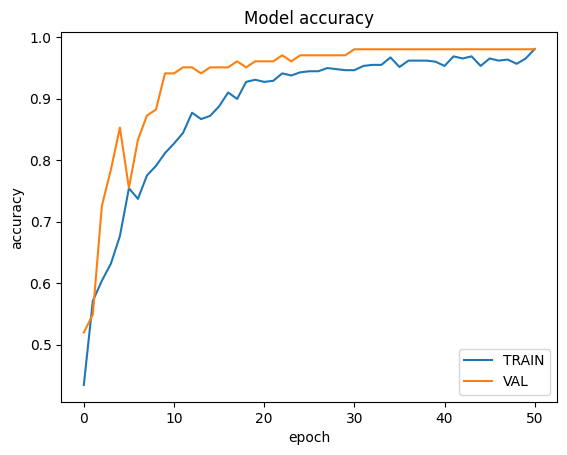

In [22]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [23]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

 1/14 [=>............................] - ETA: 0s - loss: 0.0602 - accuracy: 1.0000

14/14 [==============================] - 0s 2ms/step - loss: 0.0385 - accuracy: 0.9929


### 绘制混淆矩阵以更好地了解模型性能

 1/14 [=>............................] - ETA: 2s

14/14 [==============================] - 0s 2ms/step


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       0.98      1.00      0.99        84
       cobra       0.99      1.00      0.99        93
         dog       1.00      1.00      1.00        84
        tree       1.00      1.00      1.00        96
     warrior       1.00      0.96      0.98        68

    accuracy                           0.99       425
   macro avg       0.99      0.99      0.99       425
weighted avg       0.99      0.99      0.99       425



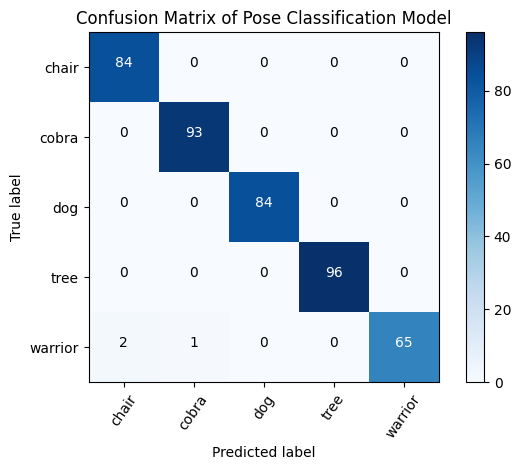

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### （可选）调查错误预测

您可以查看来自 `TEST` 数据集中被错误预测的姿态，以查看是否可以提高模型准确率。

注：这仅在您运行了第 1 步时才有效，因为您需要本地计算机上的姿势图像文件来显示它们。

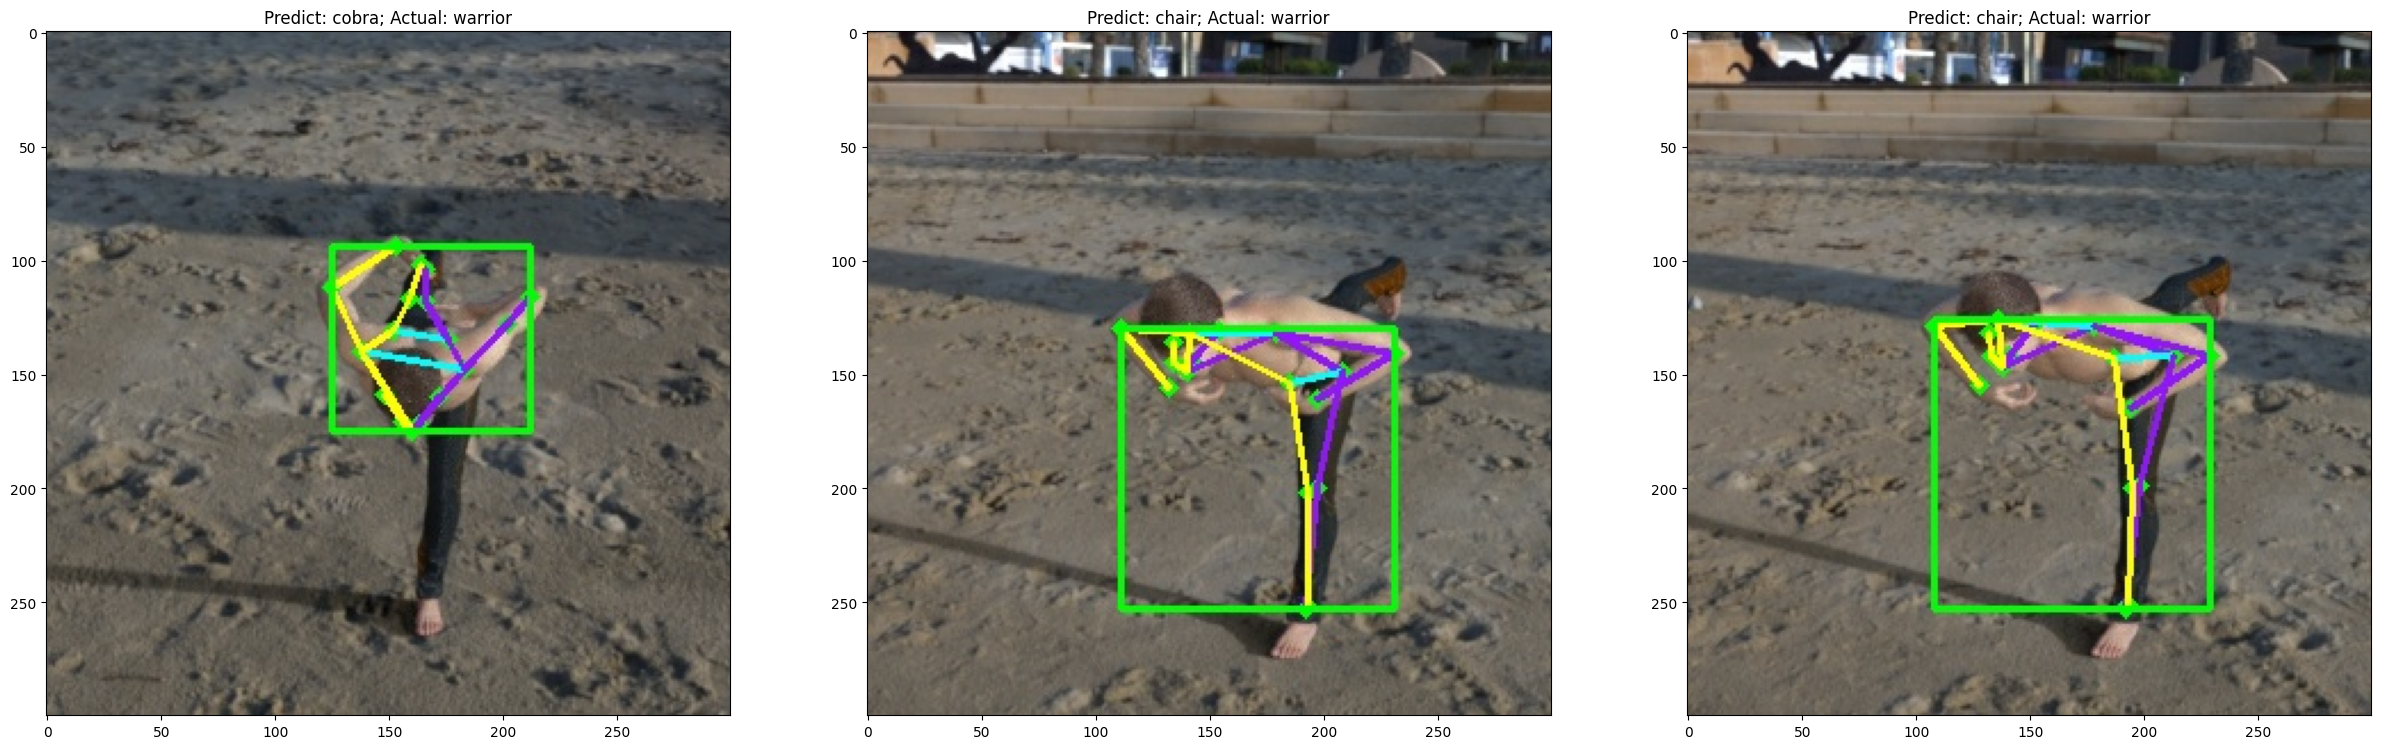

In [25]:
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## 第 3: 部分：将姿势分类模型转换为 TensorFlow Lite

您可以将 Keras 姿势分类模型转换为 TensorFlow Lite 格式，以便可以将其部署到移动应用、Web 浏览器和边缘设备。在转换模型时，您将应用[动态范围量化](https://tensorflow.google.cn/lite/performance/post_training_quant)来将姿势分类 TensorFlow Lite 模型的大小减少到约为原来的四分之一，而准确率损失不大。

注：TensorFlow Lite 支持多种量化方案。如果您有兴趣了解更多信息，请参阅[文档](https://tensorflow.google.cn/lite/performance/model_optimization)。

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp68p41hmc/assets


Model size: 26KB


2022-08-31 00:01:39.034332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-31 00:01:39.034399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


然后编写标签文件，其中包含从类索引到人类可读类名的映射。

In [27]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

由于您已经应用了量化来减小模型大小，所以我们来评估一下量化后的 TFLite 模型，以检查准确率下降是否可以接受。

In [28]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9952941176470588


现在，您可以下载 TFLite 模型 (`pose_classifier.tflite`) 和标签文件 (`pose_labels.txt`) 来对自定义姿势进行分类。有关如何使用 TFLite 姿势分类模型的端到端示例，请参阅 [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) 和 [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) 示例应用。

In [29]:
!zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

  adding: pose_labels.txt (stored 0%)
  adding: pose_classifier.tflite (deflated 34%)


In [30]:
# Download the zip archive if running on Colab.
try:
  from google.colab import files
  files.download('pose_classifier.zip')
except:
  pass